In this assignment, you will implement the REINFORCE variant of policy gradient. Then, you will use your method to solve the `CartPole` control problem.

This assignment MUST be completed using `jax` and `equinox`. If you use `torch` or `flax` or other deep learning frameworks, you will not get any points.

80 points total

- (10 points) Implement model
- (15 points) Implement helper methods
- (15 points) Implement training loop
- (40 points) Solve CartPole

In [57]:
# Import necessary libraries
!pip install equinox
# If using CUDA, uncomment this line
#!pip install jax[cuda12] jaxlib
import gymnasium as gym
import equinox as eqx
from equinox import nn
import jax
import jax.numpy as jnp
import numpy as np
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image
import optax
import cv2
import tqdm
from jaxtyping import Array, Float, Int, Bool, PyTree
from typing import Callable, Tuple, Union, List, Dict

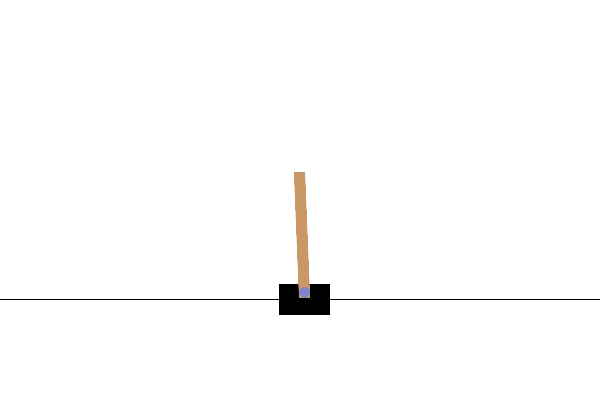

In [58]:
# Visualize the environment
# You must balance an inverted pendulum on a moving cart
# Letting the pole fall too far or moving too far to the side results in losing!
env = gym.make("CartPole-v1", render_mode="rgb_array")
np.random.seed(0)
frames = []
state, info = env.reset()
for _ in range(200):  # Run for a set number of steps
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())

    if terminated or truncated:
        state, info = env.reset()

gif_filename = "pole_test.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)
display(Image(filename=gif_filename))

In [59]:
# Some types to help you
State = Float[Array, "4"]
Action = int
Reward = Float[Array, ""]
Terminated = Bool[Array, ""]

BatchState = Float[Array, "B 4"]
BatchAction = Int[Array, "B"]
BatchReward = Float[Array, "B"]
BatchReturn = Float[Array, "B"]
BatchTerminated = Bool[Array, "B"]

Params = PyTree[Float[Array, "?"]]

(10 points) Implement the model, if you get stuck read the `equinox` documentation https://docs.kidger.site/equinox/all-of-equinox/. In RL, smaller models usually train more quickly.

In [60]:
class Model(eqx.Module):
  policy_network: eqx.Module

  def __init__(self, action_dim: int, key):
    key1, key2, key3 = jax.random.split(key, 3)
    self.policy_network = eqx.nn.Sequential([
      eqx.nn.Linear(4, 64, key=key1),
      eqx.nn.Lambda(lambda x: jax.nn.tanh(x)),
      eqx.nn.Linear(64, 32, key=key2),
      eqx.nn.Lambda(lambda x: jax.nn.tanh(x)),
      eqx.nn.Linear(32, action_dim, key=key3)
    ])
    #self.policy_network = None
    #raise NotImplementedError("TODO: Create your own policy network")
    # Personally, I like to use LayerNorm but others think it makes learning harder

  def __call__(self, state: State) -> Float[Array, "A"]:
    """Equivalent to torch module forward().
    Compute model outputs. """
    #raise NotImplementedError("TODO: Implement model forward/call")
    x = self.policy_network(state)  # 通过网络计算输出
    return jax.nn.softmax(x)


(15 points) Implement helper methods. You need to:
- Map states to actions for exploration and training
- Implement REINFORCE loss
- Implement the function that updates $\theta_\pi$

In [61]:
# Implement policies and losses
def sample_pi(model: eqx.Module, state: State, key) -> Action:
  """Given the model, sample an action from the policy distribution"""
  z = model(state)
  return jax.random.categorical(key, logits=jnp.log(z))
  #raise NotImplementedError("TODO: Using the model, map a state to randomly-sampled action")

def compute_returns(rewards: BatchReward, terminateds: BatchTerminated, gamma: float) -> BatchReturn:
    """Given a sequence of rewards and terminateds, returns the corresponding sequence of returns"""
    reversed_rewards = jnp.flip(rewards)
    reversed_dones = jnp.flip(terminateds)

    def scan_fn(carry, x):
        reward, done = x
        current_return = reward + gamma * carry * (1 - done)
        return current_return, current_return

    _, returns = jax.lax.scan(scan_fn, 0.0, (reversed_rewards, reversed_dones))
    returns = jnp.flip(returns)
    return returns

def pg_loss(
    model: Callable,
    states: BatchState,
    actions: BatchAction,
    returns: BatchReward,
  ) -> Tuple[Float[Array, ""], Dict[str, float]]:
  """The loss for REINFORCE policy gradient.

  Returns the loss and dictionary of scalars (metrics) for debugging
  """
  B = actions.shape[0]
  metrics = {"example_metric": 0}
  probs = jax.vmap(model)(states)  # 对批量状态计算概率
  log_probs = jnp.log(probs[jnp.arange(B), actions])  # 获取选中动作的对数概率
  loss = -jnp.mean(log_probs * returns)  # REINFORCE 损失
  metrics["loss"] = loss
  #raise NotImplementedError("TODO: Implement policy gradient REINFORCE loss")
  return loss, metrics


# TODO: Uncomment the below line after your code does not crash
# It will make training much faster!
@eqx.filter_jit
def update_pi(
    model: Callable,
    X: Tuple[BatchState, BatchAction, BatchReward, BatchTerminated],
    opt_state: optax.OptState,
    gamma: Float
  ) -> Tuple[optax.OptState, Float[Array, ""], Dict[str, float]]:
  """After verifying that this function works, you will want to uncomment
  @eqx.filter_jit above. This will make the function run 10x faster."""
  states, actions, rewards, terminateds = X
  returns = compute_returns(rewards, terminateds, gamma)  # 计算回报
  print(f"states shape: {states.shape}, actions shape: {actions.shape}, returns shape: {returns.shape}")
  value_and_grad_fn = eqx.filter_value_and_grad(pg_loss, has_aux=True)
  (loss, metrics), grads = value_and_grad_fn(model, states, actions, returns)
  params = eqx.filter(model, eqx.is_array)
  updates, new_opt_state = optimizer.update(grads, opt_state, params)
  new_model = eqx.apply_updates(model, updates)  # 更新模型参数
  return new_opt_state, loss, metrics
  #raise NotImplementedError("TODO: Implement the function that updates your policy")
  # NOTE: You should use has_aux=True with filter_grad to return metrics


Here are some hyperparameters that worked with my implementation. You might need to change if our models or implementations differ!

In [62]:
seed = 0
alpha = 1e-3 # Learning rate
epochs = 5_000 # How long to train the policy for
gamma = 0.95 # Decay
batch_size = 256
optimizer = optax.adamw(learning_rate=alpha)

(15 points) Now, it is time to implement your training loop. You must
- Prefill your replay buffer with at least `batch_size` states and randomly-selected actions
- Collect `s, r` from the environment
- Collect `a` from policy
- Use the `update_pi` method to update your parameters $\theta_\pi$
- Save the best performing $\theta_\pi$

I get an undiscounted return of 100 around 100 epochs. Your model and hyperparameters will differ so it may take more or fewer episodes for you. If your policy is able to get over 30 return, it is likely learning. Note that smaller networks are often much easier to train!

In [ ]:
key = jax.random.key(seed)
# Create environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Create models
key, model_key = jax.random.split(key)
model = Model(env.action_space.n, model_key)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

# Training loop
# Once you see an episode return above 30, your model is learning
# This means your code is probably correct
# You just need to wait for a while for the agent to learn to generalize
# To all possible states
num_episodes = 0
# Progress bar for logging
pbar = tqdm.tqdm(range(epochs), dynamic_ncols=True, position=0, leave=True)
terminated = True
truncated = False
episode_return = 0
best_return = -float('inf')
best_model = model

states, actions, rewards, terminateds = [], [], [], []
state, _ = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()  # 随机选择动作
    next_state, reward, terminated, truncated, _ = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    terminateds.append(terminated or truncated)
    state = next_state
    if terminated or truncated:
        state, _ = env.reset()
print(f"Pre-filled {len(states)} samples with random actions")
X = (jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(terminateds))
opt_state, loss, metrics = update_pi(model, X, opt_state, gamma)

# Train for max_env_steps
for epoch in pbar:
  # For the progress bar, you might want to use something like this:
  # pbar.set_description(f"Episode {epoch} return {episode_return:.1f}, Loss: {loss:.3f}")
  # It will print pretty information to help you track your experiment

  rewards: Union[List, jax.Array] = []
  states: Union[List, jax.Array] = []
  actions: Union[List, jax.Array] = []
  terminateds: Union[List, jax.Array] = []
  total_return = []


  for t in range(batch_size):
    if (terminated or truncated):
      state, _ = env.reset()
      total_return.append(episode_return)
      episode_return = 0
      terminated = truncated = False

    key, subkey = jax.random.split(key)
    action = sample_pi(model, state, subkey)
    next_state, reward, terminated_, truncated_, _ = env.step(action.item())
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    terminateds.append(terminated_ or truncated_)
    state = next_state
    episode_return += reward
    terminated = terminated_
    truncated = truncated_

    # 将列表转换为 JAX 数组并更新模型
  print(f"Collected {len(states)} samples in epoch {epoch}")
  X = (jnp.array(states), jnp.array(actions), jnp.array(rewards), jnp.array(terminateds))
  opt_state, loss, metrics = update_pi(model, X, opt_state, gamma)
  if episode_return > best_return:
    best_return = episode_return
    best_model = model
  pbar.set_description(f"Episode {epoch} return {episode_return:.1f}, Loss: {float(loss):.3f}")
model = best_model


    #raise NotImplementedError("TODO: Implement the rest of the train loop")

<ipython-input-60-96e000b4aba4>:11: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  eqx.nn.Linear(32, action_dim, key=key3)
  0%|          | 0/5000 [00:00<?, ?it/s]

Pre-filled 256 samples with random actions
states shape: (256, 4), actions shape: (256,), returns shape: (256,)


Episode 0 return 4.0, Loss: 5.563:   0%|          | 1/5000 [00:02<3:53:12,  2.80s/it]

Collected 256 samples in epoch 0


Episode 1 return 11.0, Loss: 5.082:   0%|          | 2/5000 [00:03<1:58:12,  1.42s/it]

Collected 256 samples in epoch 1


Episode 2 return 13.0, Loss: 7.275:   0%|          | 3/5000 [00:03<1:16:10,  1.09it/s]

Collected 256 samples in epoch 2


Episode 3 return 42.0, Loss: 6.540:   0%|          | 4/5000 [00:03<56:29,  1.47it/s]  

Collected 256 samples in epoch 3


Episode 4 return 34.0, Loss: 7.074:   0%|          | 5/5000 [00:04<45:29,  1.83it/s]

Collected 256 samples in epoch 4


Episode 5 return 14.0, Loss: 4.862:   0%|          | 6/5000 [00:04<38:38,  2.15it/s]

Collected 256 samples in epoch 5


Episode 6 return 6.0, Loss: 5.897:   0%|          | 7/5000 [00:04<34:43,  2.40it/s]

Collected 256 samples in epoch 6


Episode 7 return 8.0, Loss: 6.140:   0%|          | 8/5000 [00:05<31:52,  2.61it/s]

Collected 256 samples in epoch 7


Episode 8 return 10.0, Loss: 6.196:   0%|          | 9/5000 [00:05<29:45,  2.79it/s]

Collected 256 samples in epoch 8


Episode 9 return 9.0, Loss: 5.932:   0%|          | 10/5000 [00:05<28:24,  2.93it/s]

Collected 256 samples in epoch 9


Episode 10 return 11.0, Loss: 5.562:   0%|          | 11/5000 [00:06<27:49,  2.99it/s]

Collected 256 samples in epoch 10


Episode 11 return 29.0, Loss: 6.257:   0%|          | 12/5000 [00:06<27:01,  3.08it/s]

Collected 256 samples in epoch 11


Episode 12 return 18.0, Loss: 5.645:   0%|          | 13/5000 [00:06<26:38,  3.12it/s]

Collected 256 samples in epoch 12


Episode 13 return 24.0, Loss: 5.931:   0%|          | 14/5000 [00:06<26:40,  3.11it/s]

Collected 256 samples in epoch 13


Episode 14 return 22.0, Loss: 5.930:   0%|          | 15/5000 [00:07<26:16,  3.16it/s]

Collected 256 samples in epoch 14


Episode 15 return 13.0, Loss: 6.341:   0%|          | 16/5000 [00:07<26:16,  3.16it/s]

Collected 256 samples in epoch 15


Episode 16 return 3.0, Loss: 6.831:   0%|          | 17/5000 [00:07<26:21,  3.15it/s]

Collected 256 samples in epoch 16


Episode 17 return 4.0, Loss: 6.693:   0%|          | 18/5000 [00:08<26:08,  3.18it/s]

Collected 256 samples in epoch 17


Episode 18 return 1.0, Loss: 5.139:   0%|          | 19/5000 [00:08<25:53,  3.21it/s]

Collected 256 samples in epoch 18


Episode 19 return 7.0, Loss: 7.792:   0%|          | 20/5000 [00:08<25:48,  3.22it/s]

Collected 256 samples in epoch 19


Episode 20 return 23.0, Loss: 6.066:   0%|          | 21/5000 [00:09<26:23,  3.14it/s]

Collected 256 samples in epoch 20


Episode 21 return 12.0, Loss: 5.777:   0%|          | 22/5000 [00:09<26:05,  3.18it/s]

Collected 256 samples in epoch 21


Episode 22 return 22.0, Loss: 5.762:   0%|          | 23/5000 [00:09<25:53,  3.20it/s]

Collected 256 samples in epoch 22


Episode 23 return 23.0, Loss: 6.048:   0%|          | 24/5000 [00:10<26:02,  3.18it/s]

Collected 256 samples in epoch 23


Episode 24 return 23.0, Loss: 6.124:   0%|          | 25/5000 [00:10<25:42,  3.23it/s]

Collected 256 samples in epoch 24


Episode 25 return 8.0, Loss: 4.801:   1%|          | 26/5000 [00:10<25:20,  3.27it/s]

Collected 256 samples in epoch 25


Episode 26 return 32.0, Loss: 5.346:   1%|          | 27/5000 [00:11<25:46,  3.22it/s]

Collected 256 samples in epoch 26


Episode 27 return 6.0, Loss: 5.851:   1%|          | 28/5000 [00:11<26:01,  3.18it/s]

Collected 256 samples in epoch 27


Episode 28 return 9.0, Loss: 5.465:   1%|          | 29/5000 [00:11<25:48,  3.21it/s]

Collected 256 samples in epoch 28


Episode 29 return 22.0, Loss: 6.187:   1%|          | 30/5000 [00:11<25:55,  3.19it/s]

Collected 256 samples in epoch 29


Episode 30 return 12.0, Loss: 6.285:   1%|          | 31/5000 [00:12<26:05,  3.17it/s]

Collected 256 samples in epoch 30


Episode 31 return 15.0, Loss: 5.692:   1%|          | 32/5000 [00:12<25:54,  3.20it/s]

Collected 256 samples in epoch 31


Episode 32 return 26.0, Loss: 5.096:   1%|          | 33/5000 [00:12<25:39,  3.23it/s]

Collected 256 samples in epoch 32


Episode 33 return 26.0, Loss: 6.298:   1%|          | 34/5000 [00:13<25:51,  3.20it/s]

Collected 256 samples in epoch 33


Episode 34 return 10.0, Loss: 5.666:   1%|          | 35/5000 [00:13<28:18,  2.92it/s]

Collected 256 samples in epoch 34


Episode 35 return 23.0, Loss: 6.030:   1%|          | 36/5000 [00:14<30:28,  2.71it/s]

Collected 256 samples in epoch 35


Episode 36 return 8.0, Loss: 5.844:   1%|          | 37/5000 [00:14<30:46,  2.69it/s]

Collected 256 samples in epoch 36


Episode 37 return 4.0, Loss: 7.452:   1%|          | 38/5000 [00:14<31:05,  2.66it/s]

Collected 256 samples in epoch 37


Episode 38 return 10.0, Loss: 6.202:   1%|          | 39/5000 [00:15<32:59,  2.51it/s]

Collected 256 samples in epoch 38


Episode 39 return 11.0, Loss: 5.463:   1%|          | 40/5000 [00:15<34:27,  2.40it/s]

Collected 256 samples in epoch 39


Episode 40 return 16.0, Loss: 5.999:   1%|          | 41/5000 [00:16<36:11,  2.28it/s]

Collected 256 samples in epoch 40


Episode 41 return 7.0, Loss: 5.189:   1%|          | 42/5000 [00:16<33:55,  2.44it/s]

Collected 256 samples in epoch 41


Episode 42 return 22.0, Loss: 5.824:   1%|          | 43/5000 [00:16<31:25,  2.63it/s]

Collected 256 samples in epoch 42


Episode 43 return 10.0, Loss: 6.053:   1%|          | 44/5000 [00:17<29:43,  2.78it/s]

Collected 256 samples in epoch 43


Episode 44 return 4.0, Loss: 7.193:   1%|          | 45/5000 [00:17<28:49,  2.87it/s]

Collected 256 samples in epoch 44


Episode 45 return 13.0, Loss: 5.723:   1%|          | 46/5000 [00:17<27:50,  2.96it/s]

Collected 256 samples in epoch 45


Episode 46 return 19.0, Loss: 6.188:   1%|          | 47/5000 [00:18<27:22,  3.02it/s]

Collected 256 samples in epoch 46


Episode 47 return 15.0, Loss: 5.156:   1%|          | 48/5000 [00:18<27:12,  3.03it/s]

Collected 256 samples in epoch 47


Episode 48 return 3.0, Loss: 5.435:   1%|          | 49/5000 [00:18<26:43,  3.09it/s]

Collected 256 samples in epoch 48


Episode 49 return 23.0, Loss: 6.457:   1%|          | 50/5000 [00:19<26:24,  3.12it/s]

Collected 256 samples in epoch 49


Episode 50 return 2.0, Loss: 6.067:   1%|          | 51/5000 [00:19<26:29,  3.11it/s]

Collected 256 samples in epoch 50


Episode 51 return 11.0, Loss: 6.166:   1%|          | 52/5000 [00:19<26:18,  3.13it/s]

Collected 256 samples in epoch 51


Episode 52 return 9.0, Loss: 5.862:   1%|          | 53/5000 [00:20<26:11,  3.15it/s]

Collected 256 samples in epoch 52


Episode 53 return 42.0, Loss: 6.432:   1%|          | 54/5000 [00:20<26:25,  3.12it/s]

Collected 256 samples in epoch 53


Episode 54 return 2.0, Loss: 5.040:   1%|          | 55/5000 [00:20<26:20,  3.13it/s]

Collected 256 samples in epoch 54


Episode 55 return 32.0, Loss: 5.468:   1%|          | 56/5000 [00:21<26:33,  3.10it/s]

Collected 256 samples in epoch 55


Episode 56 return 12.0, Loss: 5.917:   1%|          | 57/5000 [00:21<26:29,  3.11it/s]

Collected 256 samples in epoch 56


Episode 57 return 19.0, Loss: 5.313:   1%|          | 58/5000 [00:21<26:58,  3.05it/s]

Collected 256 samples in epoch 57


Episode 58 return 12.0, Loss: 6.176:   1%|          | 59/5000 [00:22<26:36,  3.09it/s]

Collected 256 samples in epoch 58


Episode 59 return 23.0, Loss: 6.044:   1%|          | 60/5000 [00:22<26:30,  3.11it/s]

Collected 256 samples in epoch 59


Episode 60 return 16.0, Loss: 6.839:   1%|          | 61/5000 [00:22<26:45,  3.08it/s]

Collected 256 samples in epoch 60


Episode 61 return 7.0, Loss: 6.297:   1%|          | 62/5000 [00:22<26:45,  3.08it/s]

Collected 256 samples in epoch 61


Episode 62 return 9.0, Loss: 5.818:   1%|▏         | 63/5000 [00:23<26:24,  3.12it/s]

Collected 256 samples in epoch 62


Episode 63 return 8.0, Loss: 5.187:   1%|▏         | 64/5000 [00:23<26:28,  3.11it/s]

Collected 256 samples in epoch 63


Episode 64 return 12.0, Loss: 8.054:   1%|▏         | 65/5000 [00:23<26:33,  3.10it/s]

Collected 256 samples in epoch 64


Episode 65 return 2.0, Loss: 5.872:   1%|▏         | 66/5000 [00:24<26:53,  3.06it/s]

Collected 256 samples in epoch 65


Episode 66 return 31.0, Loss: 5.692:   1%|▏         | 67/5000 [00:24<26:53,  3.06it/s]

Collected 256 samples in epoch 66


Episode 67 return 8.0, Loss: 7.634:   1%|▏         | 68/5000 [00:24<26:26,  3.11it/s]

Collected 256 samples in epoch 67


Episode 68 return 33.0, Loss: 5.716:   1%|▏         | 69/5000 [00:25<26:20,  3.12it/s]

Collected 256 samples in epoch 68


Episode 69 return 13.0, Loss: 6.346:   1%|▏         | 70/5000 [00:25<26:23,  3.11it/s]

Collected 256 samples in epoch 69


Episode 70 return 30.0, Loss: 6.131:   1%|▏         | 71/5000 [00:25<26:08,  3.14it/s]

Collected 256 samples in epoch 70


Episode 71 return 18.0, Loss: 6.093:   1%|▏         | 72/5000 [00:26<26:07,  3.14it/s]

Collected 256 samples in epoch 71


Episode 72 return 12.0, Loss: 5.828:   1%|▏         | 73/5000 [00:26<30:04,  2.73it/s]

Collected 256 samples in epoch 72


Episode 73 return 2.0, Loss: 5.467:   1%|▏         | 74/5000 [00:27<30:34,  2.69it/s]

Collected 256 samples in epoch 73


Episode 74 return 37.0, Loss: 6.221:   2%|▏         | 75/5000 [00:27<31:42,  2.59it/s]

Collected 256 samples in epoch 74


Episode 75 return 22.0, Loss: 6.917:   2%|▏         | 76/5000 [00:27<32:35,  2.52it/s]

Collected 256 samples in epoch 75


Episode 76 return 60.0, Loss: 6.265:   2%|▏         | 77/5000 [00:28<33:43,  2.43it/s]

Collected 256 samples in epoch 76


Episode 77 return 16.0, Loss: 6.084:   2%|▏         | 78/5000 [00:28<34:47,  2.36it/s]

Collected 256 samples in epoch 77


Episode 78 return 24.0, Loss: 6.004:   2%|▏         | 79/5000 [00:29<34:02,  2.41it/s]

Collected 256 samples in epoch 78


Episode 79 return 4.0, Loss: 6.752:   2%|▏         | 80/5000 [00:29<31:30,  2.60it/s]

Collected 256 samples in epoch 79


Episode 80 return 8.0, Loss: 6.901:   2%|▏         | 81/5000 [00:29<29:54,  2.74it/s]

Collected 256 samples in epoch 80


Episode 81 return 7.0, Loss: 6.379:   2%|▏         | 82/5000 [00:30<28:28,  2.88it/s]

Collected 256 samples in epoch 81


Episode 82 return 21.0, Loss: 5.887:   2%|▏         | 83/5000 [00:30<27:30,  2.98it/s]

Collected 256 samples in epoch 82


Episode 83 return 8.0, Loss: 6.997:   2%|▏         | 84/5000 [00:30<27:28,  2.98it/s]

Collected 256 samples in epoch 83


Episode 84 return 15.0, Loss: 6.263:   2%|▏         | 85/5000 [00:31<26:35,  3.08it/s]

Collected 256 samples in epoch 84


Episode 85 return 10.0, Loss: 5.992:   2%|▏         | 86/5000 [00:31<26:09,  3.13it/s]

Collected 256 samples in epoch 85


Episode 86 return 3.0, Loss: 6.365:   2%|▏         | 87/5000 [00:31<25:49,  3.17it/s]

Collected 256 samples in epoch 86


Episode 87 return 10.0, Loss: 6.480:   2%|▏         | 88/5000 [00:31<25:55,  3.16it/s]

Collected 256 samples in epoch 87


Episode 88 return 34.0, Loss: 6.653:   2%|▏         | 89/5000 [00:32<25:36,  3.20it/s]

Collected 256 samples in epoch 88


Episode 89 return 32.0, Loss: 5.923:   2%|▏         | 90/5000 [00:32<25:47,  3.17it/s]

Collected 256 samples in epoch 89


Episode 90 return 13.0, Loss: 5.930:   2%|▏         | 91/5000 [00:32<25:57,  3.15it/s]

Collected 256 samples in epoch 90


Episode 91 return 4.0, Loss: 6.710:   2%|▏         | 92/5000 [00:33<25:56,  3.15it/s]

Collected 256 samples in epoch 91


Episode 92 return 14.0, Loss: 6.865:   2%|▏         | 93/5000 [00:33<25:49,  3.17it/s]

Collected 256 samples in epoch 92


Episode 93 return 32.0, Loss: 6.476:   2%|▏         | 94/5000 [00:33<25:53,  3.16it/s]

Collected 256 samples in epoch 93


Episode 94 return 18.0, Loss: 5.216:   2%|▏         | 95/5000 [00:34<25:58,  3.15it/s]

Collected 256 samples in epoch 94


Episode 95 return 16.0, Loss: 5.658:   2%|▏         | 96/5000 [00:34<26:12,  3.12it/s]

Collected 256 samples in epoch 95


Episode 96 return 4.0, Loss: 4.967:   2%|▏         | 97/5000 [00:34<25:58,  3.15it/s]

Collected 256 samples in epoch 96


Episode 97 return 12.0, Loss: 7.886:   2%|▏         | 98/5000 [00:35<26:09,  3.12it/s]

Collected 256 samples in epoch 97


Episode 98 return 4.0, Loss: 5.996:   2%|▏         | 99/5000 [00:35<25:54,  3.15it/s]

Collected 256 samples in epoch 98


Episode 99 return 2.0, Loss: 5.385:   2%|▏         | 100/5000 [00:35<25:54,  3.15it/s]

Collected 256 samples in epoch 99


Episode 100 return 4.0, Loss: 5.483:   2%|▏         | 101/5000 [00:36<25:53,  3.15it/s]

Collected 256 samples in epoch 100


Episode 101 return 4.0, Loss: 6.425:   2%|▏         | 102/5000 [00:36<25:42,  3.17it/s]

Collected 256 samples in epoch 101


Episode 102 return 2.0, Loss: 5.937:   2%|▏         | 103/5000 [00:36<25:35,  3.19it/s]

Collected 256 samples in epoch 102


Episode 103 return 13.0, Loss: 6.608:   2%|▏         | 104/5000 [00:37<25:40,  3.18it/s]

Collected 256 samples in epoch 103


Episode 104 return 15.0, Loss: 5.580:   2%|▏         | 105/5000 [00:37<25:19,  3.22it/s]

Collected 256 samples in epoch 104


Episode 105 return 2.0, Loss: 6.495:   2%|▏         | 106/5000 [00:37<25:11,  3.24it/s]

Collected 256 samples in epoch 105


Episode 106 return 12.0, Loss: 7.001:   2%|▏         | 107/5000 [00:37<25:32,  3.19it/s]

Collected 256 samples in epoch 106


Episode 107 return 1.0, Loss: 5.875:   2%|▏         | 108/5000 [00:38<25:24,  3.21it/s]

Collected 256 samples in epoch 107


Episode 108 return 15.0, Loss: 5.859:   2%|▏         | 109/5000 [00:38<25:31,  3.19it/s]

Collected 256 samples in epoch 108


Episode 109 return 67.0, Loss: 7.871:   2%|▏         | 110/5000 [00:38<25:16,  3.23it/s]

Collected 256 samples in epoch 109


Episode 110 return 4.0, Loss: 6.126:   2%|▏         | 111/5000 [00:39<26:57,  3.02it/s]

Collected 256 samples in epoch 110


Episode 111 return 3.0, Loss: 6.989:   2%|▏         | 112/5000 [00:39<29:35,  2.75it/s]

Collected 256 samples in epoch 111


Episode 112 return 3.0, Loss: 6.722:   2%|▏         | 113/5000 [00:40<31:25,  2.59it/s]

Collected 256 samples in epoch 112


Episode 113 return 7.0, Loss: 5.161:   2%|▏         | 114/5000 [00:40<31:44,  2.57it/s]

Collected 256 samples in epoch 113


Episode 114 return 14.0, Loss: 6.362:   2%|▏         | 115/5000 [00:40<32:27,  2.51it/s]

Collected 256 samples in epoch 114


Episode 115 return 11.0, Loss: 6.954:   2%|▏         | 116/5000 [00:41<34:29,  2.36it/s]

Collected 256 samples in epoch 115


Episode 116 return 65.0, Loss: 7.493:   2%|▏         | 117/5000 [00:41<35:15,  2.31it/s]

Collected 256 samples in epoch 116


Episode 117 return 17.0, Loss: 7.727:   2%|▏         | 118/5000 [00:42<32:50,  2.48it/s]

Collected 256 samples in epoch 117


Episode 118 return 6.0, Loss: 5.446:   2%|▏         | 119/5000 [00:42<30:24,  2.67it/s]

Collected 256 samples in epoch 118


Episode 119 return 5.0, Loss: 6.989:   2%|▏         | 120/5000 [00:42<28:44,  2.83it/s]

Collected 256 samples in epoch 119


Episode 120 return 4.0, Loss: 5.527:   2%|▏         | 121/5000 [00:43<27:31,  2.95it/s]

Collected 256 samples in epoch 120


Episode 121 return 2.0, Loss: 5.761:   2%|▏         | 122/5000 [00:43<26:47,  3.03it/s]

Collected 256 samples in epoch 121


Episode 122 return 6.0, Loss: 5.970:   2%|▏         | 123/5000 [00:43<26:28,  3.07it/s]

Collected 256 samples in epoch 122


Episode 123 return 9.0, Loss: 6.612:   2%|▏         | 124/5000 [00:44<26:12,  3.10it/s]

Collected 256 samples in epoch 123


Episode 124 return 7.0, Loss: 6.494:   2%|▎         | 125/5000 [00:44<25:55,  3.14it/s]

Collected 256 samples in epoch 124


Episode 125 return 7.0, Loss: 6.505:   3%|▎         | 126/5000 [00:44<25:39,  3.17it/s]

Collected 256 samples in epoch 125


Episode 126 return 5.0, Loss: 5.492:   3%|▎         | 127/5000 [00:45<25:34,  3.18it/s]

Collected 256 samples in epoch 126


Episode 127 return 11.0, Loss: 5.164:   3%|▎         | 128/5000 [00:45<25:43,  3.16it/s]

Collected 256 samples in epoch 127


Episode 128 return 7.0, Loss: 6.079:   3%|▎         | 129/5000 [00:45<25:29,  3.18it/s]

Collected 256 samples in epoch 128


Episode 129 return 4.0, Loss: 5.985:   3%|▎         | 130/5000 [00:46<25:45,  3.15it/s]

Collected 256 samples in epoch 129


Episode 130 return 24.0, Loss: 7.204:   3%|▎         | 131/5000 [00:46<25:39,  3.16it/s]

Collected 256 samples in epoch 130


Episode 131 return 17.0, Loss: 6.202:   3%|▎         | 132/5000 [00:46<26:11,  3.10it/s]

Collected 256 samples in epoch 131


Episode 132 return 28.0, Loss: 5.628:   3%|▎         | 133/5000 [00:46<26:10,  3.10it/s]

Collected 256 samples in epoch 132


Episode 133 return 25.0, Loss: 5.430:   3%|▎         | 134/5000 [00:47<25:53,  3.13it/s]

Collected 256 samples in epoch 133


Episode 134 return 37.0, Loss: 5.985:   3%|▎         | 135/5000 [00:47<25:52,  3.13it/s]

Collected 256 samples in epoch 134


Episode 135 return 29.0, Loss: 6.474:   3%|▎         | 136/5000 [00:47<25:28,  3.18it/s]

Collected 256 samples in epoch 135


Episode 136 return 6.0, Loss: 5.791:   3%|▎         | 137/5000 [00:48<25:22,  3.19it/s]

Collected 256 samples in epoch 136


Episode 137 return 8.0, Loss: 5.878:   3%|▎         | 138/5000 [00:48<25:33,  3.17it/s]

Collected 256 samples in epoch 137


Episode 138 return 8.0, Loss: 6.538:   3%|▎         | 139/5000 [00:48<25:33,  3.17it/s]

Collected 256 samples in epoch 138


Episode 139 return 26.0, Loss: 6.021:   3%|▎         | 140/5000 [00:49<25:27,  3.18it/s]

Collected 256 samples in epoch 139


Episode 140 return 4.0, Loss: 6.894:   3%|▎         | 141/5000 [00:49<25:33,  3.17it/s]

Collected 256 samples in epoch 140


Episode 141 return 11.0, Loss: 5.773:   3%|▎         | 142/5000 [00:49<25:34,  3.17it/s]

Collected 256 samples in epoch 141


Episode 142 return 10.0, Loss: 5.281:   3%|▎         | 143/5000 [00:50<25:27,  3.18it/s]

Collected 256 samples in epoch 142


Episode 143 return 21.0, Loss: 5.509:   3%|▎         | 144/5000 [00:50<25:06,  3.22it/s]

Collected 256 samples in epoch 143


Episode 144 return 1.0, Loss: 5.848:   3%|▎         | 145/5000 [00:50<25:10,  3.21it/s]

Collected 256 samples in epoch 144


Episode 145 return 11.0, Loss: 6.038:   3%|▎         | 146/5000 [00:51<25:21,  3.19it/s]

Collected 256 samples in epoch 145


Episode 146 return 14.0, Loss: 5.813:   3%|▎         | 147/5000 [00:51<24:58,  3.24it/s]

Collected 256 samples in epoch 146


Episode 147 return 13.0, Loss: 6.975:   3%|▎         | 148/5000 [00:51<25:04,  3.23it/s]

Collected 256 samples in epoch 147


Episode 148 return 2.0, Loss: 6.384:   3%|▎         | 149/5000 [00:51<25:43,  3.14it/s]

Collected 256 samples in epoch 148


Episode 149 return 6.0, Loss: 5.608:   3%|▎         | 150/5000 [00:52<28:35,  2.83it/s]

Collected 256 samples in epoch 149


Episode 150 return 15.0, Loss: 5.100:   3%|▎         | 151/5000 [00:52<30:21,  2.66it/s]

Collected 256 samples in epoch 150


Episode 151 return 20.0, Loss: 5.838:   3%|▎         | 152/5000 [00:53<31:08,  2.59it/s]

Collected 256 samples in epoch 151


Episode 152 return 21.0, Loss: 6.753:   3%|▎         | 153/5000 [00:53<31:46,  2.54it/s]

Collected 256 samples in epoch 152


Episode 153 return 2.0, Loss: 5.557:   3%|▎         | 154/5000 [00:54<32:31,  2.48it/s]

Collected 256 samples in epoch 153


Episode 154 return 40.0, Loss: 6.054:   3%|▎         | 155/5000 [00:54<34:19,  2.35it/s]

Collected 256 samples in epoch 154


Episode 155 return 20.0, Loss: 6.748:   3%|▎         | 156/5000 [00:54<32:59,  2.45it/s]

Collected 256 samples in epoch 155


Episode 156 return 12.0, Loss: 5.860:   3%|▎         | 157/5000 [00:55<30:24,  2.65it/s]

Collected 256 samples in epoch 156


Episode 157 return 18.0, Loss: 5.742:   3%|▎         | 158/5000 [00:55<28:28,  2.83it/s]

Collected 256 samples in epoch 157


Episode 158 return 53.0, Loss: 6.739:   3%|▎         | 159/5000 [00:55<27:29,  2.93it/s]

Collected 256 samples in epoch 158


Episode 159 return 7.0, Loss: 6.759:   3%|▎         | 160/5000 [00:56<26:46,  3.01it/s]

Collected 256 samples in epoch 159


Episode 160 return 4.0, Loss: 6.134:   3%|▎         | 161/5000 [00:56<25:54,  3.11it/s]

Collected 256 samples in epoch 160


Episode 161 return 6.0, Loss: 7.068:   3%|▎         | 162/5000 [00:56<26:04,  3.09it/s]

Collected 256 samples in epoch 161


Episode 162 return 21.0, Loss: 5.853:   3%|▎         | 163/5000 [00:57<25:44,  3.13it/s]

Collected 256 samples in epoch 162


Episode 163 return 16.0, Loss: 5.389:   3%|▎         | 164/5000 [00:57<25:25,  3.17it/s]

Collected 256 samples in epoch 163


Episode 164 return 2.0, Loss: 5.741:   3%|▎         | 165/5000 [00:57<25:29,  3.16it/s]

Collected 256 samples in epoch 164


Episode 165 return 17.0, Loss: 6.137:   3%|▎         | 166/5000 [00:58<25:50,  3.12it/s]

Collected 256 samples in epoch 165


Episode 166 return 13.0, Loss: 5.689:   3%|▎         | 167/5000 [00:58<25:33,  3.15it/s]

Collected 256 samples in epoch 166


Episode 167 return 27.0, Loss: 6.340:   3%|▎         | 168/5000 [00:58<25:23,  3.17it/s]

Collected 256 samples in epoch 167


Episode 168 return 40.0, Loss: 7.110:   3%|▎         | 169/5000 [00:59<25:37,  3.14it/s]

Collected 256 samples in epoch 168


Episode 169 return 10.0, Loss: 5.275:   3%|▎         | 170/5000 [00:59<25:32,  3.15it/s]

Collected 256 samples in epoch 169


Episode 170 return 5.0, Loss: 5.886:   3%|▎         | 171/5000 [00:59<25:18,  3.18it/s]

Collected 256 samples in epoch 170


Episode 171 return 17.0, Loss: 7.029:   3%|▎         | 172/5000 [00:59<25:51,  3.11it/s]

Collected 256 samples in epoch 171


Episode 172 return 15.0, Loss: 6.526:   3%|▎         | 173/5000 [01:00<25:33,  3.15it/s]

Collected 256 samples in epoch 172


Episode 173 return 22.0, Loss: 6.111:   3%|▎         | 174/5000 [01:00<25:20,  3.17it/s]

Collected 256 samples in epoch 173


Episode 174 return 19.0, Loss: 6.102:   4%|▎         | 175/5000 [01:00<25:40,  3.13it/s]

Collected 256 samples in epoch 174


Episode 175 return 4.0, Loss: 6.225:   4%|▎         | 176/5000 [01:01<25:39,  3.13it/s]

Collected 256 samples in epoch 175


Episode 176 return 23.0, Loss: 6.450:   4%|▎         | 177/5000 [01:01<25:15,  3.18it/s]

Collected 256 samples in epoch 176


Episode 177 return 14.0, Loss: 5.068:   4%|▎         | 178/5000 [01:01<25:12,  3.19it/s]

Collected 256 samples in epoch 177


Episode 178 return 3.0, Loss: 5.277:   4%|▎         | 179/5000 [01:02<25:29,  3.15it/s]

Collected 256 samples in epoch 178


Episode 179 return 2.0, Loss: 6.134:   4%|▎         | 180/5000 [01:02<25:16,  3.18it/s]

Collected 256 samples in epoch 179


Episode 180 return 5.0, Loss: 6.612:   4%|▎         | 181/5000 [01:02<25:14,  3.18it/s]

Collected 256 samples in epoch 180


Episode 181 return 13.0, Loss: 6.878:   4%|▎         | 182/5000 [01:03<25:30,  3.15it/s]

Collected 256 samples in epoch 181


Episode 182 return 16.0, Loss: 5.682:   4%|▎         | 183/5000 [01:03<25:04,  3.20it/s]

Collected 256 samples in epoch 182


Episode 183 return 27.0, Loss: 5.421:   4%|▎         | 184/5000 [01:03<24:54,  3.22it/s]

Collected 256 samples in epoch 183


Episode 184 return 12.0, Loss: 6.097:   4%|▎         | 185/5000 [01:04<25:02,  3.20it/s]

Collected 256 samples in epoch 184


Episode 185 return 23.0, Loss: 5.665:   4%|▎         | 186/5000 [01:04<24:58,  3.21it/s]

Collected 256 samples in epoch 185


Episode 186 return 11.0, Loss: 5.259:   4%|▎         | 187/5000 [01:04<24:59,  3.21it/s]

Collected 256 samples in epoch 186


Episode 187 return 26.0, Loss: 5.867:   4%|▍         | 188/5000 [01:05<28:07,  2.85it/s]

Collected 256 samples in epoch 187


Episode 188 return 13.0, Loss: 5.894:   4%|▍         | 189/5000 [01:05<29:45,  2.69it/s]

Collected 256 samples in epoch 188


Episode 189 return 2.0, Loss: 5.724:   4%|▍         | 190/5000 [01:05<30:07,  2.66it/s]

Collected 256 samples in epoch 189


Episode 190 return 49.0, Loss: 6.316:   4%|▍         | 191/5000 [01:06<30:52,  2.60it/s]

Collected 256 samples in epoch 190


Episode 191 return 15.0, Loss: 7.182:   4%|▍         | 192/5000 [01:06<31:38,  2.53it/s]

Collected 256 samples in epoch 191


Episode 192 return 11.0, Loss: 5.611:   4%|▍         | 193/5000 [01:07<33:16,  2.41it/s]

Collected 256 samples in epoch 192


Episode 193 return 1.0, Loss: 5.535:   4%|▍         | 194/5000 [01:07<34:04,  2.35it/s]

Collected 256 samples in epoch 193


Episode 194 return 7.0, Loss: 5.699:   4%|▍         | 195/5000 [01:07<31:29,  2.54it/s]

Collected 256 samples in epoch 194


Episode 195 return 30.0, Loss: 6.766:   4%|▍         | 196/5000 [01:08<29:48,  2.69it/s]

Collected 256 samples in epoch 195


Episode 196 return 33.0, Loss: 6.976:   4%|▍         | 197/5000 [01:08<28:27,  2.81it/s]

Collected 256 samples in epoch 196


Episode 197 return 10.0, Loss: 5.607:   4%|▍         | 198/5000 [01:08<27:17,  2.93it/s]

Collected 256 samples in epoch 197


Episode 198 return 11.0, Loss: 5.376:   4%|▍         | 199/5000 [01:09<26:51,  2.98it/s]

Collected 256 samples in epoch 198


Episode 199 return 9.0, Loss: 6.454:   4%|▍         | 200/5000 [01:09<26:17,  3.04it/s]

Collected 256 samples in epoch 199


Episode 200 return 9.0, Loss: 6.261:   4%|▍         | 201/5000 [01:09<25:46,  3.10it/s]

Collected 256 samples in epoch 200


Episode 201 return 6.0, Loss: 5.567:   4%|▍         | 202/5000 [01:10<25:33,  3.13it/s]

Collected 256 samples in epoch 201


Episode 202 return 4.0, Loss: 5.692:   4%|▍         | 203/5000 [01:10<25:35,  3.12it/s]

Collected 256 samples in epoch 202


Episode 203 return 14.0, Loss: 5.177:   4%|▍         | 204/5000 [01:10<25:18,  3.16it/s]

Collected 256 samples in epoch 203


Episode 204 return 3.0, Loss: 5.769:   4%|▍         | 205/5000 [01:11<25:14,  3.17it/s]

Collected 256 samples in epoch 204


Episode 205 return 14.0, Loss: 6.361:   4%|▍         | 206/5000 [01:11<25:30,  3.13it/s]

Collected 256 samples in epoch 205


Episode 206 return 48.0, Loss: 7.338:   4%|▍         | 207/5000 [01:11<25:13,  3.17it/s]

Collected 256 samples in epoch 206


Episode 207 return 39.0, Loss: 5.998:   4%|▍         | 208/5000 [01:12<25:28,  3.13it/s]

Collected 256 samples in epoch 207


Episode 208 return 3.0, Loss: 6.256:   4%|▍         | 209/5000 [01:12<25:29,  3.13it/s]

Collected 256 samples in epoch 208


Episode 209 return 58.0, Loss: 6.832:   4%|▍         | 210/5000 [01:12<25:06,  3.18it/s]

Collected 256 samples in epoch 209


Episode 210 return 56.0, Loss: 7.643:   4%|▍         | 211/5000 [01:13<25:28,  3.13it/s]

Collected 256 samples in epoch 210


Episode 211 return 7.0, Loss: 5.240:   4%|▍         | 212/5000 [01:13<25:17,  3.16it/s]

Collected 256 samples in epoch 211


Episode 212 return 11.0, Loss: 6.239:   4%|▍         | 213/5000 [01:13<25:12,  3.16it/s]

Collected 256 samples in epoch 212


Episode 213 return 1.0, Loss: 5.868:   4%|▍         | 214/5000 [01:13<25:02,  3.18it/s]

Collected 256 samples in epoch 213


Episode 214 return 33.0, Loss: 6.577:   4%|▍         | 215/5000 [01:14<24:50,  3.21it/s]

Collected 256 samples in epoch 214


Episode 215 return 3.0, Loss: 7.513:   4%|▍         | 216/5000 [01:14<24:59,  3.19it/s]

Collected 256 samples in epoch 215


Episode 216 return 7.0, Loss: 6.230:   4%|▍         | 217/5000 [01:14<24:41,  3.23it/s]

Collected 256 samples in epoch 216


Episode 217 return 12.0, Loss: 6.192:   4%|▍         | 218/5000 [01:15<24:38,  3.23it/s]

Collected 256 samples in epoch 217


Episode 218 return 53.0, Loss: 6.174:   4%|▍         | 219/5000 [01:15<24:46,  3.22it/s]

Collected 256 samples in epoch 218


Episode 219 return 10.0, Loss: 6.817:   4%|▍         | 220/5000 [01:15<24:51,  3.20it/s]

Collected 256 samples in epoch 219


Episode 220 return 37.0, Loss: 7.204:   4%|▍         | 221/5000 [01:16<25:07,  3.17it/s]

Collected 256 samples in epoch 220


Episode 221 return 5.0, Loss: 6.007:   4%|▍         | 222/5000 [01:16<25:22,  3.14it/s]

Collected 256 samples in epoch 221


Episode 222 return 27.0, Loss: 5.888:   4%|▍         | 223/5000 [01:16<25:32,  3.12it/s]

Collected 256 samples in epoch 222


Episode 223 return 10.0, Loss: 6.273:   4%|▍         | 224/5000 [01:17<25:38,  3.11it/s]

Collected 256 samples in epoch 223


Episode 224 return 7.0, Loss: 6.457:   4%|▍         | 225/5000 [01:17<25:12,  3.16it/s]

Collected 256 samples in epoch 224


Episode 225 return 7.0, Loss: 6.314:   5%|▍         | 226/5000 [01:17<26:36,  2.99it/s]

Collected 256 samples in epoch 225


Episode 226 return 9.0, Loss: 5.371:   5%|▍         | 227/5000 [01:18<29:14,  2.72it/s]

Collected 256 samples in epoch 226


Episode 227 return 24.0, Loss: 6.040:   5%|▍         | 228/5000 [01:18<31:38,  2.51it/s]

Collected 256 samples in epoch 227


Episode 228 return 28.0, Loss: 6.816:   5%|▍         | 229/5000 [01:19<32:07,  2.48it/s]

Collected 256 samples in epoch 228


Episode 229 return 18.0, Loss: 5.260:   5%|▍         | 230/5000 [01:19<31:56,  2.49it/s]

Collected 256 samples in epoch 229


Episode 230 return 14.0, Loss: 7.452:   5%|▍         | 231/5000 [01:19<33:02,  2.41it/s]

Collected 256 samples in epoch 230


Episode 231 return 46.0, Loss: 7.402:   5%|▍         | 232/5000 [01:20<34:18,  2.32it/s]

Collected 256 samples in epoch 231


Episode 232 return 10.0, Loss: 5.560:   5%|▍         | 233/5000 [01:20<32:16,  2.46it/s]

Collected 256 samples in epoch 232


Episode 233 return 2.0, Loss: 5.498:   5%|▍         | 234/5000 [01:21<30:19,  2.62it/s]

Collected 256 samples in epoch 233


Episode 234 return 13.0, Loss: 5.894:   5%|▍         | 235/5000 [01:21<28:40,  2.77it/s]

Collected 256 samples in epoch 234


Episode 235 return 18.0, Loss: 5.367:   5%|▍         | 236/5000 [01:21<27:49,  2.85it/s]

Collected 256 samples in epoch 235


Episode 236 return 5.0, Loss: 6.814:   5%|▍         | 237/5000 [01:22<26:57,  2.94it/s]

Collected 256 samples in epoch 236


Episode 237 return 29.0, Loss: 6.447:   5%|▍         | 238/5000 [01:22<26:12,  3.03it/s]

Collected 256 samples in epoch 237


Episode 238 return 31.0, Loss: 6.186:   5%|▍         | 239/5000 [01:22<25:53,  3.07it/s]

Collected 256 samples in epoch 238


Episode 239 return 22.0, Loss: 5.623:   5%|▍         | 240/5000 [01:23<26:01,  3.05it/s]

Collected 256 samples in epoch 239


Episode 240 return 24.0, Loss: 6.422:   5%|▍         | 241/5000 [01:23<25:50,  3.07it/s]

Collected 256 samples in epoch 240


Episode 241 return 40.0, Loss: 6.489:   5%|▍         | 242/5000 [01:23<25:23,  3.12it/s]

Collected 256 samples in epoch 241


Episode 242 return 19.0, Loss: 6.463:   5%|▍         | 243/5000 [01:23<25:37,  3.09it/s]

Collected 256 samples in epoch 242


Episode 243 return 12.0, Loss: 6.256:   5%|▍         | 244/5000 [01:24<25:15,  3.14it/s]

Collected 256 samples in epoch 243


Episode 244 return 12.0, Loss: 5.224:   5%|▍         | 245/5000 [01:24<24:58,  3.17it/s]

Collected 256 samples in epoch 244


Episode 245 return 12.0, Loss: 5.952:   5%|▍         | 246/5000 [01:24<25:13,  3.14it/s]

Collected 256 samples in epoch 245


Episode 246 return 9.0, Loss: 6.229:   5%|▍         | 247/5000 [01:25<25:14,  3.14it/s]

Collected 256 samples in epoch 246


Episode 247 return 17.0, Loss: 5.521:   5%|▍         | 248/5000 [01:25<24:54,  3.18it/s]

Collected 256 samples in epoch 247


Episode 248 return 20.0, Loss: 5.655:   5%|▍         | 249/5000 [01:25<25:10,  3.15it/s]

Collected 256 samples in epoch 248


Episode 249 return 11.0, Loss: 7.741:   5%|▌         | 250/5000 [01:26<25:11,  3.14it/s]

Collected 256 samples in epoch 249


Episode 250 return 9.0, Loss: 6.020:   5%|▌         | 251/5000 [01:26<24:48,  3.19it/s]

Collected 256 samples in epoch 250


Episode 251 return 2.0, Loss: 5.499:   5%|▌         | 252/5000 [01:26<24:54,  3.18it/s]

Collected 256 samples in epoch 251


Episode 252 return 31.0, Loss: 7.282:   5%|▌         | 253/5000 [01:27<25:18,  3.13it/s]

Collected 256 samples in epoch 252


Episode 253 return 14.0, Loss: 6.657:   5%|▌         | 254/5000 [01:27<24:59,  3.17it/s]

Collected 256 samples in epoch 253


Episode 254 return 9.0, Loss: 5.563:   5%|▌         | 255/5000 [01:27<24:44,  3.20it/s]

Collected 256 samples in epoch 254


Episode 255 return 17.0, Loss: 6.185:   5%|▌         | 256/5000 [01:28<25:14,  3.13it/s]

Collected 256 samples in epoch 255


Episode 256 return 12.0, Loss: 6.069:   5%|▌         | 257/5000 [01:28<24:52,  3.18it/s]

Collected 256 samples in epoch 256


Episode 257 return 5.0, Loss: 6.997:   5%|▌         | 258/5000 [01:28<24:32,  3.22it/s]

Collected 256 samples in epoch 257


Episode 258 return 11.0, Loss: 5.239:   5%|▌         | 259/5000 [01:29<25:01,  3.16it/s]

Collected 256 samples in epoch 258


Episode 259 return 15.0, Loss: 6.975:   5%|▌         | 260/5000 [01:29<24:30,  3.22it/s]

Collected 256 samples in epoch 259


Episode 260 return 20.0, Loss: 5.332:   5%|▌         | 261/5000 [01:29<24:18,  3.25it/s]

Collected 256 samples in epoch 260


Episode 261 return 4.0, Loss: 6.850:   5%|▌         | 262/5000 [01:29<24:29,  3.23it/s]

Collected 256 samples in epoch 261


Episode 262 return 10.0, Loss: 6.134:   5%|▌         | 263/5000 [01:30<24:48,  3.18it/s]

Collected 256 samples in epoch 262


Episode 263 return 24.0, Loss: 6.742:   5%|▌         | 264/5000 [01:30<25:21,  3.11it/s]

Collected 256 samples in epoch 263


Episode 264 return 3.0, Loss: 5.555:   5%|▌         | 265/5000 [01:31<28:45,  2.74it/s]

Collected 256 samples in epoch 264


Episode 265 return 30.0, Loss: 5.203:   5%|▌         | 266/5000 [01:31<29:16,  2.70it/s]

Collected 256 samples in epoch 265


Episode 266 return 30.0, Loss: 5.367:   5%|▌         | 267/5000 [01:31<30:50,  2.56it/s]

Collected 256 samples in epoch 266


Episode 267 return 6.0, Loss: 5.397:   5%|▌         | 268/5000 [01:32<31:57,  2.47it/s]

Collected 256 samples in epoch 267


Episode 268 return 24.0, Loss: 7.068:   5%|▌         | 269/5000 [01:32<32:53,  2.40it/s]

Collected 256 samples in epoch 268


Episode 269 return 8.0, Loss: 7.721:   5%|▌         | 270/5000 [01:33<34:05,  2.31it/s]

Collected 256 samples in epoch 269


Episode 270 return 20.0, Loss: 6.881:   5%|▌         | 271/5000 [01:33<33:50,  2.33it/s]

Collected 256 samples in epoch 270


Episode 271 return 24.0, Loss: 5.967:   5%|▌         | 272/5000 [01:34<31:28,  2.50it/s]

Collected 256 samples in epoch 271


Episode 272 return 19.0, Loss: 6.179:   5%|▌         | 273/5000 [01:34<29:35,  2.66it/s]

Collected 256 samples in epoch 272


Episode 273 return 30.0, Loss: 7.363:   5%|▌         | 274/5000 [01:34<28:26,  2.77it/s]

Collected 256 samples in epoch 273


Episode 274 return 15.0, Loss: 5.607:   6%|▌         | 275/5000 [01:34<27:45,  2.84it/s]

Collected 256 samples in epoch 274


Episode 275 return 37.0, Loss: 5.488:   6%|▌         | 276/5000 [01:35<27:17,  2.89it/s]

Collected 256 samples in epoch 275


Episode 276 return 11.0, Loss: 6.563:   6%|▌         | 277/5000 [01:35<26:37,  2.96it/s]

Collected 256 samples in epoch 276


Episode 277 return 14.0, Loss: 5.475:   6%|▌         | 278/5000 [01:35<26:15,  3.00it/s]

Collected 256 samples in epoch 277


Episode 278 return 13.0, Loss: 6.866:   6%|▌         | 279/5000 [01:36<26:08,  3.01it/s]

Collected 256 samples in epoch 278


Episode 279 return 32.0, Loss: 6.261:   6%|▌         | 280/5000 [01:36<25:41,  3.06it/s]

Collected 256 samples in epoch 279


Episode 280 return 21.0, Loss: 6.555:   6%|▌         | 281/5000 [01:36<25:17,  3.11it/s]

Collected 256 samples in epoch 280


Episode 281 return 6.0, Loss: 6.315:   6%|▌         | 282/5000 [01:37<25:11,  3.12it/s]

Collected 256 samples in epoch 281


Episode 282 return 35.0, Loss: 6.377:   6%|▌         | 283/5000 [01:37<25:26,  3.09it/s]

Collected 256 samples in epoch 282


Episode 283 return 13.0, Loss: 5.746:   6%|▌         | 284/5000 [01:37<25:13,  3.12it/s]

Collected 256 samples in epoch 283


Episode 284 return 10.0, Loss: 5.123:   6%|▌         | 285/5000 [01:38<25:22,  3.10it/s]

Collected 256 samples in epoch 284


Episode 285 return 31.0, Loss: 5.423:   6%|▌         | 286/5000 [01:38<25:15,  3.11it/s]

Collected 256 samples in epoch 285


Episode 286 return 9.0, Loss: 5.956:   6%|▌         | 287/5000 [01:38<24:56,  3.15it/s]

Collected 256 samples in epoch 286


Episode 287 return 3.0, Loss: 4.847:   6%|▌         | 288/5000 [01:39<25:03,  3.13it/s]

Collected 256 samples in epoch 287


Episode 288 return 14.0, Loss: 5.417:   6%|▌         | 289/5000 [01:39<25:11,  3.12it/s]

Collected 256 samples in epoch 288


Episode 289 return 8.0, Loss: 5.752:   6%|▌         | 290/5000 [01:39<24:52,  3.16it/s]

Collected 256 samples in epoch 289


Episode 290 return 8.0, Loss: 4.972:   6%|▌         | 291/5000 [01:40<24:44,  3.17it/s]

Collected 256 samples in epoch 290


Episode 291 return 16.0, Loss: 5.854:   6%|▌         | 292/5000 [01:40<25:10,  3.12it/s]

Collected 256 samples in epoch 291


Episode 292 return 10.0, Loss: 6.434:   6%|▌         | 293/5000 [01:40<24:46,  3.17it/s]

Collected 256 samples in epoch 292


Episode 293 return 14.0, Loss: 5.514:   6%|▌         | 294/5000 [01:41<24:53,  3.15it/s]

Collected 256 samples in epoch 293


Episode 294 return 25.0, Loss: 6.342:   6%|▌         | 295/5000 [01:41<24:50,  3.16it/s]

Collected 256 samples in epoch 294


Episode 295 return 7.0, Loss: 7.463:   6%|▌         | 296/5000 [01:41<25:04,  3.13it/s]

Collected 256 samples in epoch 295


Episode 296 return 15.0, Loss: 5.798:   6%|▌         | 297/5000 [01:42<24:59,  3.14it/s]

Collected 256 samples in epoch 296


Episode 297 return 4.0, Loss: 6.400:   6%|▌         | 298/5000 [01:42<24:47,  3.16it/s]

Collected 256 samples in epoch 297


Episode 298 return 18.0, Loss: 6.890:   6%|▌         | 299/5000 [01:42<24:57,  3.14it/s]

Collected 256 samples in epoch 298


Episode 299 return 4.0, Loss: 5.776:   6%|▌         | 300/5000 [01:42<24:40,  3.18it/s]

Collected 256 samples in epoch 299


Episode 300 return 15.0, Loss: 6.032:   6%|▌         | 301/5000 [01:43<24:38,  3.18it/s]

Collected 256 samples in epoch 300


Episode 301 return 10.0, Loss: 6.956:   6%|▌         | 302/5000 [01:43<25:50,  3.03it/s]

Collected 256 samples in epoch 301


Episode 302 return 8.0, Loss: 7.259:   6%|▌         | 303/5000 [01:44<29:36,  2.64it/s]

Collected 256 samples in epoch 302


Episode 303 return 22.0, Loss: 6.217:   6%|▌         | 304/5000 [01:44<31:17,  2.50it/s]

Collected 256 samples in epoch 303


Episode 304 return 3.0, Loss: 6.764:   6%|▌         | 305/5000 [01:45<32:19,  2.42it/s]

Collected 256 samples in epoch 304


Episode 305 return 33.0, Loss: 5.634:   6%|▌         | 306/5000 [01:45<33:10,  2.36it/s]

Collected 256 samples in epoch 305


Episode 306 return 3.0, Loss: 6.169:   6%|▌         | 307/5000 [01:45<35:03,  2.23it/s]

Collected 256 samples in epoch 306


Episode 307 return 1.0, Loss: 5.939:   6%|▌         | 308/5000 [01:46<35:08,  2.22it/s]

Collected 256 samples in epoch 307


Episode 308 return 19.0, Loss: 5.716:   6%|▌         | 309/5000 [01:46<32:44,  2.39it/s]

Collected 256 samples in epoch 308


Episode 309 return 7.0, Loss: 7.131:   6%|▌         | 310/5000 [01:47<30:41,  2.55it/s]

Collected 256 samples in epoch 309


Episode 310 return 4.0, Loss: 6.479:   6%|▌         | 311/5000 [01:47<28:42,  2.72it/s]

Collected 256 samples in epoch 310


Episode 311 return 16.0, Loss: 7.018:   6%|▌         | 312/5000 [01:47<28:01,  2.79it/s]

Collected 256 samples in epoch 311


Episode 312 return 5.0, Loss: 5.409:   6%|▋         | 313/5000 [01:48<27:18,  2.86it/s]

Collected 256 samples in epoch 312


Episode 313 return 9.0, Loss: 4.750:   6%|▋         | 314/5000 [01:48<26:25,  2.96it/s]

Collected 256 samples in epoch 313


Episode 314 return 6.0, Loss: 5.841:   6%|▋         | 315/5000 [01:48<26:03,  3.00it/s]

Collected 256 samples in epoch 314


Episode 315 return 9.0, Loss: 6.439:   6%|▋         | 316/5000 [01:49<26:06,  2.99it/s]

Collected 256 samples in epoch 315


Episode 316 return 8.0, Loss: 6.235:   6%|▋         | 317/5000 [01:49<25:19,  3.08it/s]

Collected 256 samples in epoch 316


Episode 317 return 6.0, Loss: 6.764:   6%|▋         | 318/5000 [01:49<25:02,  3.12it/s]

Collected 256 samples in epoch 317


Episode 318 return 9.0, Loss: 4.926:   6%|▋         | 319/5000 [01:50<25:31,  3.06it/s]

Collected 256 samples in epoch 318


Episode 319 return 12.0, Loss: 5.496:   6%|▋         | 320/5000 [01:50<25:11,  3.10it/s]

Collected 256 samples in epoch 319


Episode 320 return 16.0, Loss: 6.128:   6%|▋         | 321/5000 [01:50<25:02,  3.11it/s]

Collected 256 samples in epoch 320


Episode 321 return 14.0, Loss: 5.877:   6%|▋         | 322/5000 [01:50<25:19,  3.08it/s]

Collected 256 samples in epoch 321


Episode 322 return 1.0, Loss: 5.649:   6%|▋         | 323/5000 [01:51<25:02,  3.11it/s]

Collected 256 samples in epoch 322


Episode 323 return 15.0, Loss: 5.929:   6%|▋         | 324/5000 [01:51<24:42,  3.15it/s]

Collected 256 samples in epoch 323


Episode 324 return 16.0, Loss: 6.065:   6%|▋         | 325/5000 [01:51<24:48,  3.14it/s]

Collected 256 samples in epoch 324


Episode 325 return 23.0, Loss: 6.247:   7%|▋         | 326/5000 [01:52<24:44,  3.15it/s]

Collected 256 samples in epoch 325


Episode 326 return 11.0, Loss: 4.658:   7%|▋         | 327/5000 [01:52<24:40,  3.16it/s]

Collected 256 samples in epoch 326


Episode 327 return 12.0, Loss: 5.663:   7%|▋         | 328/5000 [01:52<24:26,  3.19it/s]

Collected 256 samples in epoch 327


Episode 328 return 23.0, Loss: 6.294:   7%|▋         | 329/5000 [01:53<24:41,  3.15it/s]

Collected 256 samples in epoch 328


Episode 329 return 6.0, Loss: 5.813:   7%|▋         | 330/5000 [01:53<24:28,  3.18it/s]

Collected 256 samples in epoch 329


Episode 330 return 2.0, Loss: 5.115:   7%|▋         | 331/5000 [01:53<24:14,  3.21it/s]

Collected 256 samples in epoch 330


Episode 331 return 14.0, Loss: 5.541:   7%|▋         | 332/5000 [01:54<24:40,  3.15it/s]

Collected 256 samples in epoch 331


Episode 332 return 1.0, Loss: 6.388:   7%|▋         | 333/5000 [01:54<24:33,  3.17it/s]

Collected 256 samples in epoch 332


Episode 333 return 8.0, Loss: 6.424:   7%|▋         | 334/5000 [01:54<24:23,  3.19it/s]

Collected 256 samples in epoch 333


Episode 334 return 2.0, Loss: 6.327:   7%|▋         | 335/5000 [01:55<24:40,  3.15it/s]

Collected 256 samples in epoch 334


Episode 335 return 8.0, Loss: 6.081:   7%|▋         | 336/5000 [01:55<24:37,  3.16it/s]

Collected 256 samples in epoch 335


Episode 336 return 9.0, Loss: 6.217:   7%|▋         | 337/5000 [01:55<24:38,  3.15it/s]

Collected 256 samples in epoch 336


Episode 337 return 5.0, Loss: 5.354:   7%|▋         | 338/5000 [01:56<25:23,  3.06it/s]

Collected 256 samples in epoch 337


Episode 338 return 17.0, Loss: 5.638:   7%|▋         | 339/5000 [01:56<25:19,  3.07it/s]

Collected 256 samples in epoch 338


Episode 339 return 20.0, Loss: 5.018:   7%|▋         | 340/5000 [01:56<28:34,  2.72it/s]

Collected 256 samples in epoch 339


Episode 340 return 14.0, Loss: 5.875:   7%|▋         | 341/5000 [01:57<30:55,  2.51it/s]

Collected 256 samples in epoch 340


Episode 341 return 18.0, Loss: 5.395:   7%|▋         | 342/5000 [01:57<31:25,  2.47it/s]

Collected 256 samples in epoch 341


Episode 342 return 9.0, Loss: 5.591:   7%|▋         | 343/5000 [01:58<32:28,  2.39it/s]

Collected 256 samples in epoch 342


Episode 343 return 6.0, Loss: 5.215:   7%|▋         | 344/5000 [01:58<32:36,  2.38it/s]

Collected 256 samples in epoch 343


Episode 344 return 2.0, Loss: 5.698:   7%|▋         | 345/5000 [01:59<33:53,  2.29it/s]

Collected 256 samples in epoch 344


Episode 345 return 14.0, Loss: 5.066:   7%|▋         | 346/5000 [01:59<33:31,  2.31it/s]

Collected 256 samples in epoch 345


Episode 346 return 13.0, Loss: 6.657:   7%|▋         | 347/5000 [01:59<30:47,  2.52it/s]

Collected 256 samples in epoch 346


Episode 347 return 15.0, Loss: 5.450:   7%|▋         | 348/5000 [02:00<28:44,  2.70it/s]

Collected 256 samples in epoch 347


Episode 348 return 28.0, Loss: 6.201:   7%|▋         | 349/5000 [02:00<27:41,  2.80it/s]

Collected 256 samples in epoch 348


Episode 349 return 58.0, Loss: 7.460:   7%|▋         | 350/5000 [02:00<26:44,  2.90it/s]

Collected 256 samples in epoch 349


Episode 350 return 6.0, Loss: 5.815:   7%|▋         | 351/5000 [02:01<26:06,  2.97it/s]

Collected 256 samples in epoch 350


Episode 351 return 4.0, Loss: 7.363:   7%|▋         | 352/5000 [02:01<25:39,  3.02it/s]

Collected 256 samples in epoch 351


Episode 352 return 12.0, Loss: 6.192:   7%|▋         | 353/5000 [02:01<25:03,  3.09it/s]

Collected 256 samples in epoch 352


Episode 353 return 20.0, Loss: 6.392:   7%|▋         | 354/5000 [02:02<24:49,  3.12it/s]

Collected 256 samples in epoch 353


Episode 354 return 10.0, Loss: 5.832:   7%|▋         | 355/5000 [02:02<25:00,  3.10it/s]

Collected 256 samples in epoch 354


Episode 355 return 30.0, Loss: 6.099:   7%|▋         | 356/5000 [02:02<24:59,  3.10it/s]

Collected 256 samples in epoch 355


Episode 356 return 6.0, Loss: 7.778:   7%|▋         | 357/5000 [02:02<24:50,  3.12it/s]

Collected 256 samples in epoch 356


Episode 357 return 5.0, Loss: 5.289:   7%|▋         | 358/5000 [02:03<24:59,  3.10it/s]

Collected 256 samples in epoch 357


Episode 358 return 4.0, Loss: 6.104:   7%|▋         | 359/5000 [02:03<24:35,  3.14it/s]

Collected 256 samples in epoch 358


Episode 359 return 35.0, Loss: 5.665:   7%|▋         | 360/5000 [02:03<24:12,  3.19it/s]

Collected 256 samples in epoch 359


Episode 360 return 41.0, Loss: 5.698:   7%|▋         | 361/5000 [02:04<24:17,  3.18it/s]

Collected 256 samples in epoch 360


Episode 361 return 3.0, Loss: 5.267:   7%|▋         | 362/5000 [02:04<24:43,  3.13it/s]

Collected 256 samples in epoch 361


Episode 362 return 37.0, Loss: 6.716:   7%|▋         | 363/5000 [02:04<24:38,  3.14it/s]

Collected 256 samples in epoch 362


Episode 363 return 31.0, Loss: 6.541:   7%|▋         | 364/5000 [02:05<24:42,  3.13it/s]

Collected 256 samples in epoch 363


Episode 364 return 3.0, Loss: 7.096:   7%|▋         | 365/5000 [02:05<24:53,  3.10it/s]

Collected 256 samples in epoch 364


Episode 365 return 9.0, Loss: 5.722:   7%|▋         | 366/5000 [02:05<24:35,  3.14it/s]

Collected 256 samples in epoch 365


Episode 366 return 11.0, Loss: 5.271:   7%|▋         | 367/5000 [02:06<24:48,  3.11it/s]

Collected 256 samples in epoch 366


Episode 367 return 3.0, Loss: 5.356:   7%|▋         | 368/5000 [02:06<25:13,  3.06it/s]

Collected 256 samples in epoch 367


Episode 368 return 6.0, Loss: 5.348:   7%|▋         | 369/5000 [02:06<24:46,  3.12it/s]

Collected 256 samples in epoch 368


Episode 369 return 9.0, Loss: 5.286:   7%|▋         | 370/5000 [02:07<24:52,  3.10it/s]

Collected 256 samples in epoch 369


Episode 370 return 9.0, Loss: 6.813:   7%|▋         | 371/5000 [02:07<25:05,  3.07it/s]

Collected 256 samples in epoch 370


Episode 371 return 10.0, Loss: 5.280:   7%|▋         | 372/5000 [02:07<24:53,  3.10it/s]

Collected 256 samples in epoch 371


Episode 372 return 2.0, Loss: 6.720:   7%|▋         | 373/5000 [02:08<24:59,  3.09it/s]

Collected 256 samples in epoch 372


Episode 373 return 25.0, Loss: 6.299:   7%|▋         | 374/5000 [02:08<24:39,  3.13it/s]

Collected 256 samples in epoch 373


Episode 374 return 13.0, Loss: 7.272:   8%|▊         | 375/5000 [02:08<24:55,  3.09it/s]

Collected 256 samples in epoch 374


Episode 375 return 3.0, Loss: 6.860:   8%|▊         | 376/5000 [02:09<24:35,  3.13it/s]

Collected 256 samples in epoch 375


Episode 376 return 6.0, Loss: 5.587:   8%|▊         | 377/5000 [02:09<24:32,  3.14it/s]

Collected 256 samples in epoch 376


Episode 377 return 22.0, Loss: 5.690:   8%|▊         | 378/5000 [02:09<28:19,  2.72it/s]

Collected 256 samples in epoch 377


Episode 378 return 7.0, Loss: 5.089:   8%|▊         | 379/5000 [02:10<30:21,  2.54it/s]

Collected 256 samples in epoch 378


Episode 379 return 8.0, Loss: 7.598:   8%|▊         | 380/5000 [02:10<31:47,  2.42it/s]

Collected 256 samples in epoch 379


Episode 380 return 1.0, Loss: 6.038:   8%|▊         | 381/5000 [02:11<30:53,  2.49it/s]

Collected 256 samples in epoch 380


Episode 381 return 9.0, Loss: 6.636:   8%|▊         | 382/5000 [02:11<30:58,  2.48it/s]

Collected 256 samples in epoch 381


Episode 382 return 4.0, Loss: 4.879:   8%|▊         | 383/5000 [02:12<32:32,  2.36it/s]

Collected 256 samples in epoch 382


Episode 383 return 12.0, Loss: 6.093:   8%|▊         | 384/5000 [02:12<32:16,  2.38it/s]

Collected 256 samples in epoch 383


Episode 384 return 13.0, Loss: 6.797:   8%|▊         | 385/5000 [02:12<29:58,  2.57it/s]

Collected 256 samples in epoch 384


Episode 385 return 11.0, Loss: 6.602:   8%|▊         | 386/5000 [02:13<28:15,  2.72it/s]

Collected 256 samples in epoch 385


Episode 386 return 1.0, Loss: 5.064:   8%|▊         | 387/5000 [02:13<26:53,  2.86it/s]

Collected 256 samples in epoch 386


Episode 387 return 23.0, Loss: 6.115:   8%|▊         | 388/5000 [02:13<26:24,  2.91it/s]

Collected 256 samples in epoch 387


Episode 388 return 5.0, Loss: 5.901:   8%|▊         | 389/5000 [02:14<26:04,  2.95it/s]

Collected 256 samples in epoch 388


Episode 389 return 6.0, Loss: 5.529:   8%|▊         | 390/5000 [02:14<25:26,  3.02it/s]

Collected 256 samples in epoch 389


Episode 390 return 10.0, Loss: 7.132:   8%|▊         | 391/5000 [02:14<24:57,  3.08it/s]

Collected 256 samples in epoch 390


Episode 391 return 44.0, Loss: 6.828:   8%|▊         | 392/5000 [02:15<25:15,  3.04it/s]

Collected 256 samples in epoch 391


Episode 392 return 6.0, Loss: 5.878:   8%|▊         | 393/5000 [02:15<24:55,  3.08it/s]

Collected 256 samples in epoch 392


Episode 393 return 13.0, Loss: 6.109:   8%|▊         | 394/5000 [02:15<24:38,  3.11it/s]

Collected 256 samples in epoch 393


Episode 394 return 24.0, Loss: 7.579:   8%|▊         | 395/5000 [02:15<25:13,  3.04it/s]

Collected 256 samples in epoch 394


Episode 395 return 17.0, Loss: 5.429:   8%|▊         | 396/5000 [02:16<25:12,  3.04it/s]

Collected 256 samples in epoch 395


Episode 396 return 19.0, Loss: 7.850:   8%|▊         | 397/5000 [02:16<25:07,  3.05it/s]

Collected 256 samples in epoch 396


Episode 397 return 17.0, Loss: 4.792:   8%|▊         | 398/5000 [02:17<25:57,  2.95it/s]

Collected 256 samples in epoch 397


Episode 398 return 16.0, Loss: 6.234:   8%|▊         | 399/5000 [02:17<25:31,  3.00it/s]

Collected 256 samples in epoch 398


Episode 399 return 12.0, Loss: 4.990:   8%|▊         | 400/5000 [02:17<24:57,  3.07it/s]

Collected 256 samples in epoch 399


Episode 400 return 6.0, Loss: 6.007:   8%|▊         | 401/5000 [02:17<24:34,  3.12it/s]

Collected 256 samples in epoch 400


Episode 401 return 37.0, Loss: 7.027:   8%|▊         | 402/5000 [02:18<24:53,  3.08it/s]

Collected 256 samples in epoch 401


Episode 402 return 21.0, Loss: 5.628:   8%|▊         | 403/5000 [02:18<24:39,  3.11it/s]

Collected 256 samples in epoch 402


Episode 403 return 11.0, Loss: 4.946:   8%|▊         | 404/5000 [02:18<24:18,  3.15it/s]

Collected 256 samples in epoch 403


Episode 404 return 5.0, Loss: 7.881:   8%|▊         | 405/5000 [02:19<24:45,  3.09it/s]

Collected 256 samples in epoch 404


Episode 405 return 13.0, Loss: 6.204:   8%|▊         | 406/5000 [02:19<24:20,  3.14it/s]

Collected 256 samples in epoch 405


Episode 406 return 9.0, Loss: 5.658:   8%|▊         | 407/5000 [02:19<24:28,  3.13it/s]

Collected 256 samples in epoch 406


Episode 407 return 7.0, Loss: 6.173:   8%|▊         | 408/5000 [02:20<24:34,  3.11it/s]

Collected 256 samples in epoch 407


Episode 408 return 8.0, Loss: 6.138:   8%|▊         | 409/5000 [02:20<24:21,  3.14it/s]

Collected 256 samples in epoch 408


Episode 409 return 17.0, Loss: 6.412:   8%|▊         | 410/5000 [02:20<24:10,  3.16it/s]

Collected 256 samples in epoch 409


Episode 410 return 6.0, Loss: 5.095:   8%|▊         | 411/5000 [02:21<24:51,  3.08it/s]

Collected 256 samples in epoch 410


Episode 411 return 6.0, Loss: 5.231:   8%|▊         | 412/5000 [02:21<24:39,  3.10it/s]

Collected 256 samples in epoch 411


Episode 412 return 31.0, Loss: 5.757:   8%|▊         | 413/5000 [02:21<24:23,  3.13it/s]

Collected 256 samples in epoch 412


Episode 413 return 14.0, Loss: 7.021:   8%|▊         | 414/5000 [02:22<24:15,  3.15it/s]

Collected 256 samples in epoch 413


Episode 414 return 4.0, Loss: 6.952:   8%|▊         | 415/5000 [02:22<26:03,  2.93it/s]

Collected 256 samples in epoch 414


Episode 415 return 15.0, Loss: 6.216:   8%|▊         | 416/5000 [02:22<28:47,  2.65it/s]

Collected 256 samples in epoch 415


Episode 416 return 4.0, Loss: 5.330:   8%|▊         | 417/5000 [02:23<29:46,  2.56it/s]

Collected 256 samples in epoch 416


Episode 417 return 11.0, Loss: 6.098:   8%|▊         | 418/5000 [02:23<30:59,  2.46it/s]

Collected 256 samples in epoch 417


Episode 418 return 2.0, Loss: 5.885:   8%|▊         | 419/5000 [02:24<31:12,  2.45it/s]

Collected 256 samples in epoch 418


Episode 419 return 10.0, Loss: 5.735:   8%|▊         | 420/5000 [02:24<32:41,  2.34it/s]

Collected 256 samples in epoch 419


Episode 420 return 5.0, Loss: 5.714:   8%|▊         | 421/5000 [02:25<33:40,  2.27it/s]

Collected 256 samples in epoch 420


Episode 421 return 28.0, Loss: 5.928:   8%|▊         | 422/5000 [02:25<32:23,  2.36it/s]

Collected 256 samples in epoch 421


Episode 422 return 32.0, Loss: 6.174:   8%|▊         | 423/5000 [02:25<30:01,  2.54it/s]

Collected 256 samples in epoch 422


Episode 423 return 4.0, Loss: 5.308:   8%|▊         | 424/5000 [02:26<28:22,  2.69it/s]

Collected 256 samples in epoch 423


Episode 424 return 4.0, Loss: 5.960:   8%|▊         | 425/5000 [02:26<27:35,  2.76it/s]

Collected 256 samples in epoch 424


Episode 425 return 2.0, Loss: 6.333:   9%|▊         | 426/5000 [02:26<26:23,  2.89it/s]

Collected 256 samples in epoch 425


Episode 426 return 35.0, Loss: 6.212:   9%|▊         | 427/5000 [02:27<25:57,  2.94it/s]

Collected 256 samples in epoch 426


Episode 427 return 8.0, Loss: 5.885:   9%|▊         | 428/5000 [02:27<25:42,  2.96it/s]

Collected 256 samples in epoch 427


Episode 428 return 28.0, Loss: 6.045:   9%|▊         | 429/5000 [02:27<25:12,  3.02it/s]

Collected 256 samples in epoch 428


Episode 429 return 28.0, Loss: 5.728:   9%|▊         | 430/5000 [02:28<25:00,  3.05it/s]

Collected 256 samples in epoch 429


Episode 430 return 21.0, Loss: 6.149:   9%|▊         | 431/5000 [02:28<24:48,  3.07it/s]

Collected 256 samples in epoch 430


Episode 431 return 9.0, Loss: 6.004:   9%|▊         | 432/5000 [02:28<24:46,  3.07it/s]

Collected 256 samples in epoch 431


Episode 432 return 11.0, Loss: 6.425:   9%|▊         | 433/5000 [02:29<24:42,  3.08it/s]

Collected 256 samples in epoch 432


Episode 433 return 7.0, Loss: 5.770:   9%|▊         | 434/5000 [02:29<24:28,  3.11it/s]

Collected 256 samples in epoch 433


Episode 434 return 10.0, Loss: 5.995:   9%|▊         | 435/5000 [02:29<24:34,  3.10it/s]

Collected 256 samples in epoch 434


Episode 435 return 11.0, Loss: 5.204:   9%|▊         | 436/5000 [02:30<24:06,  3.16it/s]

Collected 256 samples in epoch 435


Episode 436 return 4.0, Loss: 5.554:   9%|▊         | 437/5000 [02:30<24:01,  3.16it/s]

Collected 256 samples in epoch 436


Episode 437 return 9.0, Loss: 7.518:   9%|▉         | 438/5000 [02:30<24:27,  3.11it/s]

Collected 256 samples in epoch 437


Episode 438 return 28.0, Loss: 5.910:   9%|▉         | 439/5000 [02:31<24:23,  3.12it/s]

Collected 256 samples in epoch 438


Episode 439 return 12.0, Loss: 4.916:   9%|▉         | 440/5000 [02:31<24:19,  3.12it/s]

Collected 256 samples in epoch 439


Episode 440 return 49.0, Loss: 7.470:   9%|▉         | 441/5000 [02:31<24:33,  3.09it/s]

Collected 256 samples in epoch 440


Episode 441 return 12.0, Loss: 5.973:   9%|▉         | 442/5000 [02:31<24:21,  3.12it/s]

Collected 256 samples in epoch 441


Episode 442 return 16.0, Loss: 5.711:   9%|▉         | 443/5000 [02:32<24:15,  3.13it/s]

Collected 256 samples in epoch 442


Episode 443 return 8.0, Loss: 5.047:   9%|▉         | 444/5000 [02:32<24:29,  3.10it/s]

Collected 256 samples in epoch 443


Episode 444 return 15.0, Loss: 6.698:   9%|▉         | 445/5000 [02:32<24:08,  3.14it/s]

Collected 256 samples in epoch 444


Episode 445 return 3.0, Loss: 5.799:   9%|▉         | 446/5000 [02:33<23:57,  3.17it/s]

Collected 256 samples in epoch 445


Episode 446 return 2.0, Loss: 6.746:   9%|▉         | 447/5000 [02:33<23:55,  3.17it/s]

Collected 256 samples in epoch 446


Episode 447 return 18.0, Loss: 6.100:   9%|▉         | 448/5000 [02:33<24:03,  3.15it/s]

Collected 256 samples in epoch 447


Episode 448 return 18.0, Loss: 6.657:   9%|▉         | 449/5000 [02:34<24:08,  3.14it/s]

Collected 256 samples in epoch 448


Episode 449 return 10.0, Loss: 6.011:   9%|▉         | 450/5000 [02:34<24:08,  3.14it/s]

Collected 256 samples in epoch 449


Episode 450 return 9.0, Loss: 5.712:   9%|▉         | 451/5000 [02:34<24:15,  3.13it/s]

Collected 256 samples in epoch 450


Episode 451 return 9.0, Loss: 6.421:   9%|▉         | 452/5000 [02:35<24:17,  3.12it/s]

Collected 256 samples in epoch 451


Episode 452 return 20.0, Loss: 6.840:   9%|▉         | 453/5000 [02:35<25:22,  2.99it/s]

Collected 256 samples in epoch 452


Episode 453 return 11.0, Loss: 5.804:   9%|▉         | 454/5000 [02:36<28:37,  2.65it/s]

Collected 256 samples in epoch 453


Episode 454 return 3.0, Loss: 6.019:   9%|▉         | 455/5000 [02:36<30:26,  2.49it/s]

Collected 256 samples in epoch 454


Episode 455 return 13.0, Loss: 6.023:   9%|▉         | 456/5000 [02:36<30:57,  2.45it/s]

Collected 256 samples in epoch 455


Episode 456 return 2.0, Loss: 7.198:   9%|▉         | 457/5000 [02:37<31:05,  2.43it/s]

Collected 256 samples in epoch 456


Episode 457 return 8.0, Loss: 5.309:   9%|▉         | 458/5000 [02:37<31:54,  2.37it/s]

Collected 256 samples in epoch 457


Episode 458 return 12.0, Loss: 6.002:   9%|▉         | 459/5000 [02:38<32:34,  2.32it/s]

Collected 256 samples in epoch 458


Episode 459 return 15.0, Loss: 6.286:   9%|▉         | 460/5000 [02:38<30:42,  2.46it/s]

Collected 256 samples in epoch 459


Episode 460 return 11.0, Loss: 5.827:   9%|▉         | 461/5000 [02:38<28:58,  2.61it/s]

Collected 256 samples in epoch 460


Episode 461 return 6.0, Loss: 5.699:   9%|▉         | 462/5000 [02:39<27:32,  2.75it/s]

Collected 256 samples in epoch 461


Episode 462 return 9.0, Loss: 6.520:   9%|▉         | 463/5000 [02:39<26:29,  2.86it/s]

Collected 256 samples in epoch 462


Episode 463 return 33.0, Loss: 5.674:   9%|▉         | 464/5000 [02:39<25:36,  2.95it/s]

Collected 256 samples in epoch 463


Episode 464 return 22.0, Loss: 6.220:   9%|▉         | 465/5000 [02:40<25:39,  2.95it/s]

Collected 256 samples in epoch 464


Episode 465 return 7.0, Loss: 6.403:   9%|▉         | 466/5000 [02:40<25:02,  3.02it/s]

Collected 256 samples in epoch 465


Episode 466 return 13.0, Loss: 6.067:   9%|▉         | 467/5000 [02:40<24:41,  3.06it/s]

Collected 256 samples in epoch 466


Episode 467 return 8.0, Loss: 6.093:   9%|▉         | 468/5000 [02:41<24:47,  3.05it/s]

Collected 256 samples in epoch 467


Episode 468 return 18.0, Loss: 6.158:   9%|▉         | 469/5000 [02:41<24:25,  3.09it/s]

Collected 256 samples in epoch 468


Episode 469 return 10.0, Loss: 5.992:   9%|▉         | 470/5000 [02:41<24:03,  3.14it/s]

Collected 256 samples in epoch 469


Episode 470 return 35.0, Loss: 6.559:   9%|▉         | 471/5000 [02:42<24:20,  3.10it/s]

Collected 256 samples in epoch 470


Episode 471 return 10.0, Loss: 5.482:   9%|▉         | 472/5000 [02:42<24:28,  3.08it/s]

Collected 256 samples in epoch 471


Episode 472 return 7.0, Loss: 7.046:   9%|▉         | 473/5000 [02:42<24:30,  3.08it/s]

Collected 256 samples in epoch 472


Episode 473 return 10.0, Loss: 5.911:   9%|▉         | 474/5000 [02:43<24:42,  3.05it/s]

Collected 256 samples in epoch 473


Episode 474 return 39.0, Loss: 6.452:  10%|▉         | 475/5000 [02:43<24:42,  3.05it/s]

Collected 256 samples in epoch 474


Episode 475 return 7.0, Loss: 7.734:  10%|▉         | 476/5000 [02:43<24:29,  3.08it/s]

Collected 256 samples in epoch 475


Episode 476 return 16.0, Loss: 5.393:  10%|▉         | 477/5000 [02:44<24:47,  3.04it/s]

Collected 256 samples in epoch 476


Episode 477 return 59.0, Loss: 6.190:  10%|▉         | 478/5000 [02:44<24:22,  3.09it/s]

Collected 256 samples in epoch 477


Episode 478 return 6.0, Loss: 4.873:  10%|▉         | 479/5000 [02:44<24:32,  3.07it/s]

Collected 256 samples in epoch 478


Episode 479 return 23.0, Loss: 5.937:  10%|▉         | 480/5000 [02:45<24:27,  3.08it/s]

Collected 256 samples in epoch 479


Episode 480 return 6.0, Loss: 5.461:  10%|▉         | 481/5000 [02:45<24:44,  3.04it/s]

Collected 256 samples in epoch 480


Episode 481 return 10.0, Loss: 6.217:  10%|▉         | 482/5000 [02:45<24:19,  3.09it/s]

Collected 256 samples in epoch 481


Episode 482 return 10.0, Loss: 5.163:  10%|▉         | 483/5000 [02:46<24:21,  3.09it/s]

Collected 256 samples in epoch 482


Episode 483 return 6.0, Loss: 7.265:  10%|▉         | 484/5000 [02:46<24:35,  3.06it/s]

Collected 256 samples in epoch 483


Episode 484 return 1.0, Loss: 5.814:  10%|▉         | 485/5000 [02:46<24:27,  3.08it/s]

Collected 256 samples in epoch 484


Episode 485 return 5.0, Loss: 6.036:  10%|▉         | 486/5000 [02:46<24:29,  3.07it/s]

Collected 256 samples in epoch 485


Episode 486 return 3.0, Loss: 6.750:  10%|▉         | 487/5000 [02:47<25:20,  2.97it/s]

Collected 256 samples in epoch 486


Episode 487 return 1.0, Loss: 5.965:  10%|▉         | 488/5000 [02:47<24:50,  3.03it/s]

Collected 256 samples in epoch 487


Episode 488 return 15.0, Loss: 5.991:  10%|▉         | 489/5000 [02:47<24:36,  3.05it/s]

Collected 256 samples in epoch 488


Episode 489 return 61.0, Loss: 6.947:  10%|▉         | 490/5000 [02:48<24:27,  3.07it/s]

Collected 256 samples in epoch 489


Episode 490 return 12.0, Loss: 6.213:  10%|▉         | 491/5000 [02:48<26:53,  2.79it/s]

Collected 256 samples in epoch 490


Episode 491 return 38.0, Loss: 6.413:  10%|▉         | 492/5000 [02:49<28:43,  2.62it/s]

Collected 256 samples in epoch 491


Episode 492 return 6.0, Loss: 5.970:  10%|▉         | 493/5000 [02:49<30:18,  2.48it/s]

Collected 256 samples in epoch 492


Episode 493 return 6.0, Loss: 5.895:  10%|▉         | 494/5000 [02:50<30:35,  2.46it/s]

Collected 256 samples in epoch 493


Episode 494 return 39.0, Loss: 6.330:  10%|▉         | 495/5000 [02:50<31:37,  2.37it/s]

Collected 256 samples in epoch 494


Episode 495 return 33.0, Loss: 7.092:  10%|▉         | 496/5000 [02:50<32:37,  2.30it/s]

Collected 256 samples in epoch 495


Episode 496 return 10.0, Loss: 7.237:  10%|▉         | 497/5000 [02:51<32:34,  2.30it/s]

Collected 256 samples in epoch 496


Episode 497 return 11.0, Loss: 6.634:  10%|▉         | 498/5000 [02:51<29:49,  2.52it/s]

Collected 256 samples in epoch 497


Episode 498 return 10.0, Loss: 5.693:  10%|▉         | 499/5000 [02:52<28:15,  2.66it/s]

Collected 256 samples in epoch 498


Episode 499 return 16.0, Loss: 5.705:  10%|█         | 500/5000 [02:52<27:06,  2.77it/s]

Collected 256 samples in epoch 499


Episode 500 return 22.0, Loss: 6.414:  10%|█         | 501/5000 [02:52<26:16,  2.85it/s]

Collected 256 samples in epoch 500


Episode 501 return 6.0, Loss: 6.246:  10%|█         | 502/5000 [02:53<25:45,  2.91it/s]

Collected 256 samples in epoch 501


Episode 502 return 13.0, Loss: 6.074:  10%|█         | 503/5000 [02:53<24:54,  3.01it/s]

Collected 256 samples in epoch 502


Episode 503 return 10.0, Loss: 5.492:  10%|█         | 504/5000 [02:53<24:49,  3.02it/s]

Collected 256 samples in epoch 503


Episode 504 return 2.0, Loss: 5.924:  10%|█         | 505/5000 [02:53<24:33,  3.05it/s]

Collected 256 samples in epoch 504


Episode 505 return 12.0, Loss: 7.470:  10%|█         | 506/5000 [02:54<24:13,  3.09it/s]

Collected 256 samples in epoch 505


Episode 506 return 8.0, Loss: 5.758:  10%|█         | 507/5000 [02:54<24:33,  3.05it/s]

Collected 256 samples in epoch 506


Episode 507 return 2.0, Loss: 6.359:  10%|█         | 508/5000 [02:54<24:27,  3.06it/s]

Collected 256 samples in epoch 507


Episode 508 return 23.0, Loss: 5.817:  10%|█         | 509/5000 [02:55<24:18,  3.08it/s]

Collected 256 samples in epoch 508


Episode 509 return 39.0, Loss: 7.132:  10%|█         | 510/5000 [02:55<24:30,  3.05it/s]

Collected 256 samples in epoch 509


Episode 510 return 18.0, Loss: 5.545:  10%|█         | 511/5000 [02:55<24:32,  3.05it/s]

Collected 256 samples in epoch 510


Episode 511 return 6.0, Loss: 5.873:  10%|█         | 512/5000 [02:56<24:45,  3.02it/s]

Collected 256 samples in epoch 511


Episode 512 return 1.0, Loss: 5.851:  10%|█         | 513/5000 [02:56<24:52,  3.01it/s]

Collected 256 samples in epoch 512


Episode 513 return 40.0, Loss: 6.675:  10%|█         | 514/5000 [02:56<24:36,  3.04it/s]

Collected 256 samples in epoch 513


Episode 514 return 15.0, Loss: 5.361:  10%|█         | 515/5000 [02:57<24:40,  3.03it/s]

Collected 256 samples in epoch 514


Episode 515 return 5.0, Loss: 6.924:  10%|█         | 516/5000 [02:57<24:59,  2.99it/s]

Collected 256 samples in epoch 515


Episode 516 return 6.0, Loss: 7.278:  10%|█         | 517/5000 [02:57<24:32,  3.04it/s]

Collected 256 samples in epoch 516


Episode 517 return 18.0, Loss: 5.227:  10%|█         | 518/5000 [02:58<24:46,  3.01it/s]

Collected 256 samples in epoch 517


Episode 518 return 12.0, Loss: 6.172:  10%|█         | 519/5000 [02:58<24:29,  3.05it/s]

Collected 256 samples in epoch 518


Episode 519 return 12.0, Loss: 5.690:  10%|█         | 520/5000 [02:58<24:44,  3.02it/s]

Collected 256 samples in epoch 519


Episode 520 return 18.0, Loss: 6.611:  10%|█         | 521/5000 [02:59<24:38,  3.03it/s]

Collected 256 samples in epoch 520


Episode 521 return 34.0, Loss: 5.353:  10%|█         | 522/5000 [02:59<24:28,  3.05it/s]

Collected 256 samples in epoch 521


Episode 522 return 17.0, Loss: 5.991:  10%|█         | 523/5000 [02:59<24:27,  3.05it/s]

Collected 256 samples in epoch 522


Episode 523 return 19.0, Loss: 6.143:  10%|█         | 524/5000 [03:00<24:03,  3.10it/s]

Collected 256 samples in epoch 523


Episode 524 return 19.0, Loss: 6.613:  10%|█         | 525/5000 [03:00<23:48,  3.13it/s]

Collected 256 samples in epoch 524


Episode 525 return 32.0, Loss: 6.472:  11%|█         | 526/5000 [03:00<24:02,  3.10it/s]

Collected 256 samples in epoch 525


Episode 526 return 16.0, Loss: 6.974:  11%|█         | 527/5000 [03:01<23:58,  3.11it/s]

Collected 256 samples in epoch 526


Episode 527 return 1.0, Loss: 5.657:  11%|█         | 528/5000 [03:01<25:51,  2.88it/s]

Collected 256 samples in epoch 527


Episode 528 return 30.0, Loss: 7.093:  11%|█         | 529/5000 [03:02<28:30,  2.61it/s]

Collected 256 samples in epoch 528


Episode 529 return 1.0, Loss: 5.912:  11%|█         | 530/5000 [03:02<29:46,  2.50it/s]

Collected 256 samples in epoch 529


Episode 530 return 6.0, Loss: 5.496:  11%|█         | 531/5000 [03:02<31:01,  2.40it/s]

Collected 256 samples in epoch 530


Episode 531 return 11.0, Loss: 5.958:  11%|█         | 532/5000 [03:03<31:18,  2.38it/s]

Collected 256 samples in epoch 531


Episode 532 return 5.0, Loss: 5.695:  11%|█         | 533/5000 [03:03<32:14,  2.31it/s]

Collected 256 samples in epoch 532


Episode 533 return 3.0, Loss: 6.146:  11%|█         | 534/5000 [03:04<33:04,  2.25it/s]

Collected 256 samples in epoch 533


Episode 534 return 11.0, Loss: 6.232:  11%|█         | 535/5000 [03:04<30:07,  2.47it/s]

Collected 256 samples in epoch 534


Episode 535 return 33.0, Loss: 6.351:  11%|█         | 536/5000 [03:04<28:17,  2.63it/s]

Collected 256 samples in epoch 535


Episode 536 return 23.0, Loss: 5.677:  11%|█         | 537/5000 [03:05<26:59,  2.76it/s]

Collected 256 samples in epoch 536


Episode 537 return 7.0, Loss: 5.991:  11%|█         | 538/5000 [03:05<25:57,  2.87it/s]

Collected 256 samples in epoch 537


Episode 538 return 2.0, Loss: 6.215:  11%|█         | 539/5000 [03:05<25:12,  2.95it/s]

Collected 256 samples in epoch 538


Episode 539 return 2.0, Loss: 5.736:  11%|█         | 540/5000 [03:06<24:47,  3.00it/s]

Collected 256 samples in epoch 539


Episode 540 return 46.0, Loss: 6.420:  11%|█         | 541/5000 [03:06<24:10,  3.07it/s]

Collected 256 samples in epoch 540


Episode 541 return 18.0, Loss: 6.780:  11%|█         | 542/5000 [03:06<23:56,  3.10it/s]

Collected 256 samples in epoch 541


Episode 542 return 5.0, Loss: 5.428:  11%|█         | 543/5000 [03:07<23:56,  3.10it/s]

Collected 256 samples in epoch 542


Episode 543 return 31.0, Loss: 7.407:  11%|█         | 544/5000 [03:07<23:36,  3.14it/s]

Collected 256 samples in epoch 543


Episode 544 return 31.0, Loss: 5.961:  11%|█         | 545/5000 [03:07<23:37,  3.14it/s]

Collected 256 samples in epoch 544


Episode 545 return 33.0, Loss: 6.178:  11%|█         | 546/5000 [03:08<23:38,  3.14it/s]

Collected 256 samples in epoch 545


Episode 546 return 30.0, Loss: 7.064:  11%|█         | 547/5000 [03:08<23:29,  3.16it/s]

Collected 256 samples in epoch 546


Episode 547 return 8.0, Loss: 7.298:  11%|█         | 548/5000 [03:08<23:43,  3.13it/s]

Collected 256 samples in epoch 547


Episode 548 return 10.0, Loss: 6.119:  11%|█         | 549/5000 [03:09<23:45,  3.12it/s]

Collected 256 samples in epoch 548


Episode 549 return 1.0, Loss: 5.921:  11%|█         | 550/5000 [03:09<24:10,  3.07it/s]

Collected 256 samples in epoch 549


Episode 550 return 31.0, Loss: 6.082:  11%|█         | 551/5000 [03:09<23:50,  3.11it/s]

Collected 256 samples in epoch 550


Episode 551 return 7.0, Loss: 5.383:  11%|█         | 552/5000 [03:10<23:40,  3.13it/s]

Collected 256 samples in epoch 551


Episode 552 return 18.0, Loss: 6.637:  11%|█         | 553/5000 [03:10<23:54,  3.10it/s]

Collected 256 samples in epoch 552


Episode 553 return 13.0, Loss: 5.494:  11%|█         | 554/5000 [03:10<23:42,  3.13it/s]

Collected 256 samples in epoch 553


Episode 554 return 17.0, Loss: 4.843:  11%|█         | 555/5000 [03:10<23:44,  3.12it/s]

Collected 256 samples in epoch 554


Episode 555 return 9.0, Loss: 4.843:  11%|█         | 556/5000 [03:11<23:54,  3.10it/s]

Collected 256 samples in epoch 555


Episode 556 return 11.0, Loss: 5.196:  11%|█         | 557/5000 [03:11<23:50,  3.11it/s]

Collected 256 samples in epoch 556


Episode 557 return 12.0, Loss: 5.582:  11%|█         | 558/5000 [03:11<23:53,  3.10it/s]

Collected 256 samples in epoch 557


Episode 558 return 1.0, Loss: 5.759:  11%|█         | 559/5000 [03:12<24:01,  3.08it/s]

Collected 256 samples in epoch 558


Episode 559 return 7.0, Loss: 5.881:  11%|█         | 560/5000 [03:12<23:38,  3.13it/s]

Collected 256 samples in epoch 559


Episode 560 return 10.0, Loss: 5.974:  11%|█         | 561/5000 [03:12<23:41,  3.12it/s]

Collected 256 samples in epoch 560


Episode 561 return 2.0, Loss: 7.346:  11%|█         | 562/5000 [03:13<24:01,  3.08it/s]

Collected 256 samples in epoch 561


Episode 562 return 2.0, Loss: 6.355:  11%|█▏        | 563/5000 [03:13<23:53,  3.10it/s]

Collected 256 samples in epoch 562


Episode 563 return 25.0, Loss: 6.643:  11%|█▏        | 564/5000 [03:13<23:46,  3.11it/s]

Collected 256 samples in epoch 563


Episode 564 return 12.0, Loss: 5.337:  11%|█▏        | 565/5000 [03:14<23:59,  3.08it/s]

Collected 256 samples in epoch 564


Episode 565 return 3.0, Loss: 6.577:  11%|█▏        | 566/5000 [03:14<26:49,  2.75it/s]

Collected 256 samples in epoch 565


Episode 566 return 26.0, Loss: 7.164:  11%|█▏        | 567/5000 [03:15<28:18,  2.61it/s]

Collected 256 samples in epoch 566


Episode 567 return 28.0, Loss: 5.457:  11%|█▏        | 568/5000 [03:15<30:21,  2.43it/s]

Collected 256 samples in epoch 567


Episode 568 return 1.0, Loss: 6.415:  11%|█▏        | 569/5000 [03:16<30:21,  2.43it/s]

Collected 256 samples in epoch 568


Episode 569 return 5.0, Loss: 6.282:  11%|█▏        | 570/5000 [03:16<31:17,  2.36it/s]

Collected 256 samples in epoch 569


Episode 570 return 72.0, Loss: 8.491:  11%|█▏        | 571/5000 [03:16<31:13,  2.36it/s]

Collected 256 samples in epoch 570


Episode 571 return 11.0, Loss: 5.993:  11%|█▏        | 572/5000 [03:17<32:50,  2.25it/s]

Collected 256 samples in epoch 571


Episode 572 return 1.0, Loss: 5.301:  11%|█▏        | 573/5000 [03:17<30:28,  2.42it/s]

Collected 256 samples in epoch 572


Episode 573 return 43.0, Loss: 6.760:  11%|█▏        | 574/5000 [03:18<28:41,  2.57it/s]

Collected 256 samples in epoch 573


Episode 574 return 38.0, Loss: 6.682:  12%|█▏        | 575/5000 [03:18<27:12,  2.71it/s]

Collected 256 samples in epoch 574


Episode 575 return 8.0, Loss: 6.927:  12%|█▏        | 576/5000 [03:18<26:25,  2.79it/s]

Collected 256 samples in epoch 575


Episode 576 return 17.0, Loss: 5.909:  12%|█▏        | 577/5000 [03:19<25:34,  2.88it/s]

Collected 256 samples in epoch 576


Episode 577 return 8.0, Loss: 5.516:  12%|█▏        | 578/5000 [03:19<24:58,  2.95it/s]

Collected 256 samples in epoch 577


Episode 578 return 11.0, Loss: 4.847:  12%|█▏        | 579/5000 [03:19<24:52,  2.96it/s]

Collected 256 samples in epoch 578


Episode 579 return 36.0, Loss: 6.205:  12%|█▏        | 580/5000 [03:19<24:33,  3.00it/s]

Collected 256 samples in epoch 579


Episode 580 return 3.0, Loss: 6.150:  12%|█▏        | 581/5000 [03:20<24:10,  3.05it/s]

Collected 256 samples in epoch 580


Episode 581 return 23.0, Loss: 6.765:  12%|█▏        | 582/5000 [03:20<24:07,  3.05it/s]

Collected 256 samples in epoch 581


Episode 582 return 6.0, Loss: 5.167:  12%|█▏        | 583/5000 [03:20<24:07,  3.05it/s]

Collected 256 samples in epoch 582


Episode 583 return 16.0, Loss: 5.243:  12%|█▏        | 584/5000 [03:21<24:02,  3.06it/s]

Collected 256 samples in epoch 583


Episode 584 return 12.0, Loss: 8.260:  12%|█▏        | 585/5000 [03:21<23:46,  3.10it/s]

Collected 256 samples in epoch 584


Episode 585 return 9.0, Loss: 7.611:  12%|█▏        | 586/5000 [03:21<24:25,  3.01it/s]

Collected 256 samples in epoch 585


Episode 586 return 12.0, Loss: 5.104:  12%|█▏        | 587/5000 [03:22<24:14,  3.03it/s]

Collected 256 samples in epoch 586


Episode 587 return 7.0, Loss: 5.920:  12%|█▏        | 588/5000 [03:22<24:05,  3.05it/s]

Collected 256 samples in epoch 587


Episode 588 return 15.0, Loss: 6.657:  12%|█▏        | 589/5000 [03:22<24:22,  3.02it/s]

Collected 256 samples in epoch 588


Episode 589 return 17.0, Loss: 5.987:  12%|█▏        | 590/5000 [03:23<24:14,  3.03it/s]

Collected 256 samples in epoch 589


Episode 590 return 4.0, Loss: 4.865:  12%|█▏        | 591/5000 [03:23<24:00,  3.06it/s]

Collected 256 samples in epoch 590


Episode 591 return 3.0, Loss: 5.901:  12%|█▏        | 592/5000 [03:23<24:04,  3.05it/s]

Collected 256 samples in epoch 591


Episode 592 return 12.0, Loss: 5.884:  12%|█▏        | 593/5000 [03:24<24:02,  3.06it/s]

Collected 256 samples in epoch 592


Episode 593 return 1.0, Loss: 5.947:  12%|█▏        | 594/5000 [03:24<23:59,  3.06it/s]

Collected 256 samples in epoch 593


Episode 594 return 3.0, Loss: 6.071:  12%|█▏        | 595/5000 [03:24<24:01,  3.06it/s]

Collected 256 samples in epoch 594


Episode 595 return 2.0, Loss: 5.882:  12%|█▏        | 596/5000 [03:25<23:41,  3.10it/s]

Collected 256 samples in epoch 595


Episode 596 return 7.0, Loss: 5.451:  12%|█▏        | 597/5000 [03:25<23:43,  3.09it/s]

Collected 256 samples in epoch 596


Episode 597 return 1.0, Loss: 6.395:  12%|█▏        | 598/5000 [03:25<23:52,  3.07it/s]

Collected 256 samples in epoch 597


Episode 598 return 5.0, Loss: 5.206:  12%|█▏        | 599/5000 [03:26<23:46,  3.09it/s]

Collected 256 samples in epoch 598


Episode 599 return 32.0, Loss: 6.258:  12%|█▏        | 600/5000 [03:26<23:42,  3.09it/s]

Collected 256 samples in epoch 599


Episode 600 return 42.0, Loss: 6.949:  12%|█▏        | 601/5000 [03:26<23:36,  3.10it/s]

Collected 256 samples in epoch 600


Episode 601 return 5.0, Loss: 5.326:  12%|█▏        | 602/5000 [03:27<24:03,  3.05it/s]

Collected 256 samples in epoch 601


Episode 602 return 14.0, Loss: 5.955:  12%|█▏        | 603/5000 [03:27<25:13,  2.91it/s]

Collected 256 samples in epoch 602


Episode 603 return 3.0, Loss: 4.894:  12%|█▏        | 604/5000 [03:28<27:36,  2.65it/s]

Collected 256 samples in epoch 603


Episode 604 return 19.0, Loss: 5.753:  12%|█▏        | 605/5000 [03:28<28:52,  2.54it/s]

Collected 256 samples in epoch 604


Episode 605 return 30.0, Loss: 5.886:  12%|█▏        | 606/5000 [03:28<29:35,  2.47it/s]

Collected 256 samples in epoch 605


Episode 606 return 2.0, Loss: 5.997:  12%|█▏        | 607/5000 [03:29<30:16,  2.42it/s]

Collected 256 samples in epoch 606


Episode 607 return 2.0, Loss: 5.483:  12%|█▏        | 608/5000 [03:29<31:19,  2.34it/s]

Collected 256 samples in epoch 607


Episode 608 return 28.0, Loss: 6.633:  12%|█▏        | 609/5000 [03:30<32:43,  2.24it/s]

Collected 256 samples in epoch 608


Episode 609 return 30.0, Loss: 5.558:  12%|█▏        | 610/5000 [03:30<30:54,  2.37it/s]

Collected 256 samples in epoch 609


Episode 610 return 9.0, Loss: 5.425:  12%|█▏        | 611/5000 [03:30<28:34,  2.56it/s]

Collected 256 samples in epoch 610


Episode 611 return 14.0, Loss: 5.809:  12%|█▏        | 612/5000 [03:31<27:34,  2.65it/s]

Collected 256 samples in epoch 611


Episode 612 return 11.0, Loss: 5.902:  12%|█▏        | 613/5000 [03:31<26:25,  2.77it/s]

Collected 256 samples in epoch 612


Episode 613 return 3.0, Loss: 5.746:  12%|█▏        | 614/5000 [03:31<25:44,  2.84it/s]

Collected 256 samples in epoch 613


Episode 614 return 2.0, Loss: 5.334:  12%|█▏        | 615/5000 [03:32<25:38,  2.85it/s]

Collected 256 samples in epoch 614


Episode 615 return 9.0, Loss: 5.998:  12%|█▏        | 616/5000 [03:32<24:50,  2.94it/s]

Collected 256 samples in epoch 615


Episode 616 return 11.0, Loss: 5.733:  12%|█▏        | 617/5000 [03:32<24:27,  2.99it/s]

Collected 256 samples in epoch 616


Episode 617 return 4.0, Loss: 5.544:  12%|█▏        | 618/5000 [03:33<24:30,  2.98it/s]

Collected 256 samples in epoch 617


Episode 618 return 4.0, Loss: 5.477:  12%|█▏        | 619/5000 [03:33<24:08,  3.02it/s]

Collected 256 samples in epoch 618


Episode 619 return 28.0, Loss: 6.444:  12%|█▏        | 620/5000 [03:33<24:06,  3.03it/s]

Collected 256 samples in epoch 619


Episode 620 return 4.0, Loss: 6.279:  12%|█▏        | 621/5000 [03:34<24:13,  3.01it/s]

Collected 256 samples in epoch 620


Episode 621 return 9.0, Loss: 6.475:  12%|█▏        | 622/5000 [03:34<24:05,  3.03it/s]

Collected 256 samples in epoch 621


Episode 622 return 10.0, Loss: 5.837:  12%|█▏        | 623/5000 [03:34<23:53,  3.05it/s]

Collected 256 samples in epoch 622


Episode 623 return 1.0, Loss: 6.982:  12%|█▏        | 624/5000 [03:35<23:50,  3.06it/s]

Collected 256 samples in epoch 623


Episode 624 return 2.0, Loss: 5.979:  12%|█▎        | 625/5000 [03:35<23:58,  3.04it/s]

Collected 256 samples in epoch 624


Episode 625 return 2.0, Loss: 8.055:  13%|█▎        | 626/5000 [03:35<23:49,  3.06it/s]

Collected 256 samples in epoch 625


Episode 626 return 13.0, Loss: 6.255:  13%|█▎        | 627/5000 [03:36<23:37,  3.08it/s]

Collected 256 samples in epoch 626


Episode 627 return 56.0, Loss: 6.793:  13%|█▎        | 628/5000 [03:36<23:43,  3.07it/s]

Collected 256 samples in epoch 627


Episode 628 return 11.0, Loss: 7.156:  13%|█▎        | 629/5000 [03:36<23:29,  3.10it/s]

Collected 256 samples in epoch 628


Episode 629 return 15.0, Loss: 5.821:  13%|█▎        | 630/5000 [03:37<23:24,  3.11it/s]

Collected 256 samples in epoch 629


Episode 630 return 52.0, Loss: 6.640:  13%|█▎        | 631/5000 [03:37<23:33,  3.09it/s]

Collected 256 samples in epoch 630


Episode 631 return 37.0, Loss: 6.400:  13%|█▎        | 632/5000 [03:37<23:24,  3.11it/s]

Collected 256 samples in epoch 631


Episode 632 return 13.0, Loss: 6.468:  13%|█▎        | 632/5000 [03:38<23:24,  3.11it/s]

(40 points) Solve the task! You must get a return of 100 or greater, balancing the pole for more than 100 timesteps.

In [ ]:
# Visualize your policy
# Use for debugging, and also for the final result!
env = gym.make("CartPole-v1", render_mode="rgb_array")

# You can try changing the seed to view different episodes
seed = 0
np.random.seed(seed)
env.action_space.seed(seed)
frames = []
state, info = env.reset(seed=0)
the_return = 0
terminated = truncated = False
key = jax.random.key(seed)
while not (terminated or truncated):
    key, _ = jax.random.split(key)
    action = sample_pi(model, state, key).item()
    next_state, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
    state = next_state
    the_return += reward

gif_filename = "pole_trained.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)
display(Image(filename=gif_filename))
print(f"Return: {the_return:.1f}")